### COMS4060A/7056A: Assignment #1
**University of the Witwatersrand**  
**Lecturer:** Muhammad Nasir (<muhammad.nasir@wits.ac.za>)  
**Date:** September 2025

---

**Group Name:** *Visionaries*

**Members**

- Karabo Mohapeloa
- Taruna Naidoo - 2546838
- Humani Nenzhelele - 1602841
- Daniel Ngobe - 2556833


## 1. Data Cleaning

This dataset relies heavily on user input from around the world. Expect issues such as:
- **`date fueled`** sometimes containing free-text descriptions instead of dates.
- **Numeric fields** (e.g., `gallons`, `miles`, `odometer`) written with thousands separators (e.g., `1,523.50`) that must be cleaned before conversion.
- **Cost fields** (`cost per gallon`, `total spent`) that include currency symbols (e.g., `R500`, `$500`) across many currencies.

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import math
import scipy.stats as stats
import warnings 
import matplotlib
import matplotlib.cm as cm
sns.set(rc={'figure.figsize':(12,6)})
warnings.simplefilter(action='ignore', category= FutureWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

%matplotlib inline

import missingno

In [2]:
df = pd.read_csv(
    "logbook_assignment1.csv",
    low_memory=False  # avoids the warning, but doesn't fix dirty values
)

df.shape

(1174870, 9)

In [3]:
df.sample(5)

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url
416868,Nov 7 2019,Nov 7 2019,"29,820",17.829,Rs268.39,"Rs4,785.04",20.2,NaN,https://www.somewebsite.com/ford/endeavour/201...
1125655,Apr 28 2021,Apr 28 2021,"67,116",17.980,Skr58.45,"Skr1,050.85",18.3,NaN,https://www.somewebsite.com/audi/a7_quattro/20...
483625,Apr 24 2017,May 11 2018,"120,486",13.016,€4.49,€58.48,21.6,NaN,https://www.somewebsite.com/bmw/323i/1997/799353
774852,Jan 14 2022,Jan 14 2022,"144,789",18.411,$3.199,$58.90,15.3,NaN,https://www.somewebsite.com/honda/pilot/2006/1...
741400,Asda,Feb 26 2016,"21,096",9.275,£3.77,£35.00,27.4,NaN,https://www.somewebsite.com/peugeot/207/2010/1...


### 1.1 Date Fields

#### 1. Identify the **percentage of `date_fueled` entries that are not valid dates**. 

In [4]:
valid_dates = pd.to_datetime(df['date_fueled'], format='%b %d %Y', errors='coerce').notna()
perc_invalid_dates = sum(valid_dates == False)/len(df)*100
print('Percentage of date_fueled entries not proper dates:', perc_invalid_dates, '%')
print('Number of invalid date_fueled entries:', sum(valid_dates == False))

Percentage of date_fueled entries not proper dates: 11.678738924306518 %
Number of invalid date_fueled entries: 137210


#### 2. Where `date_fueled` is invalid but **`date_captured` is valid**, **fill** `date_fueled` with `date_captured` as a proxy. 

In [5]:
valid_ = pd.to_datetime(df['date_captured'], format='%b %d %Y', errors='coerce').notna()
val_cap = sum(valid_ == True)/len(df)*100
print('Valid dates_captured:', val_cap, "%")
df['date_fueled_proxy'] = pd.to_datetime(np.where((pd.to_datetime(df['date_fueled'], format='%b %d %Y', errors='coerce').notna() == False),df['date_captured'],df['date_fueled']), format='%b %d %Y', errors='coerce')

Valid dates_captured: 100.0 %


#### 3. **Convert** `date fueled` to a date type; set any invalid entries to **NaT**.

In [6]:
df['date_fueled'] = pd.to_datetime(df['date_fueled'], format='%b %d %Y', errors='coerce')
df['date_captured'] = pd.to_datetime(df['date_captured'], format='%b %d %Y', errors='coerce')

print(df.dtypes)
df.sample(5)

date_fueled          datetime64[ns]
date_captured        datetime64[ns]
odometer                     object
gallons                      object
cost_per_gallon              object
total_spent                  object
mpg                          object
miles                        object
user_url                     object
date_fueled_proxy    datetime64[ns]
dtype: object


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,date_fueled_proxy
614126,2017-07-07,2017-10-24,"63,984",11.000,$48.680,$535.49,34.6,NaN,https://www.somewebsite.com/renault/clio/2013/...,2017-07-07
776158,2020-07-04,2020-07-04,"92,966",9.076,$2.159,$19.60,29.0,NaN,https://www.somewebsite.com/ford/focus/2002/95...,2020-07-04
759341,2019-09-27,2019-09-27,"56,738",6.907,"Rp28,958","Rp200,002",49.2,NaN,https://www.somewebsite.com/toyota/avanza/2010...,2019-09-27
182888,2021-09-21,2021-09-21,"282,129",15.719,$2.969,$46.67,16.8,NaN,https://www.somewebsite.com/nissan/300zx/1987/...,2021-09-21
281971,2021-03-25,2021-03-26,"113,902",12.479,$4.728,$59.00,36.2,NaN,https://www.somewebsite.com/bmw/120d/2008/592696,2021-03-25


#### 4. **Remove dates** that are in the **future** or **earlier than 2005**.

In [7]:
print("Before removing invalid dates, the shape of the dataframe is:", df.shape)

df = df.loc[(df['date_fueled_proxy'] >= '2005-01-01') & (df['date_fueled_proxy'] <= datetime.datetime.now())]

print("After removing invalid dates, the shape of the dataframe is:", df.shape)

Before removing invalid dates, the shape of the dataframe is: (1174870, 10)
After removing invalid dates, the shape of the dataframe is: (1174300, 10)



#### 5. **Plot the distribution** of fueling dates and **comment** on the results. 

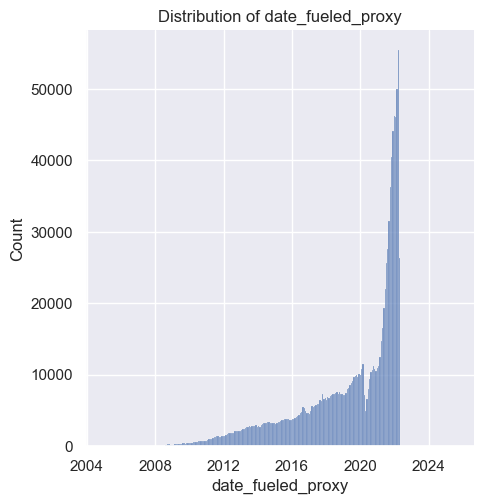

In [8]:
sns.displot(df, x="date_fueled_proxy")
plt.title("Distribution of date_fueled_proxy")
plt.show()

The distribution of fueling dates shows a gradual increase from 2005, suggesting that more users were logging fuel data over time, likely due to the platform gaining popularity. The sudden dip around 2020 could correspond to the global COVID-19 pandemic, when lockdowns and travel restrictions sharply reduced vehicle usage. The subsequent rapid increase may reflect a rebound as restrictions eased and more users returned where acustomed to digital spaces because of working from home.

### 1.2 Numeric Fields

#### 1. Identify what percentage of `gallons`, `miles`, and `odometer` entries are missing

In [9]:
percent_nulls = (df[['gallons', 'miles', 'odometer', 'mpg']].isna().sum()/len(df))*100
print(percent_nulls.astype(str) + ' %')

gallons      6.316188367538107 %
miles        87.55369156092992 %
odometer    12.691560929915694 %
mpg          6.316188367538107 %
dtype: object


#### 2. The `miles`, `gallons` and `mpg` columns are interdependent. If one is missing, the other two can be used to calculate it.

In [10]:
df['miles'] = df['miles'].replace(',', '', regex=True).astype(float)
df['odometer'] = df['odometer'].replace(',', '', regex=True).astype(float)
df['gallons'] = df['gallons'].replace(',', '', regex=True).astype(float)
df['mpg'] = df['mpg'].replace(',', '', regex=True).astype(float)

#The formula to calculate mpg: Miles driven ÷ gallons used to refill the tank
df['mpg'] = df['mpg'].fillna(df['miles']/df['gallons'])

#Formula for Miles: mpg*gallons
df['miles'] = df['miles'].fillna(df['mpg']*df['gallons'])

#Formula for gallons: miles/mpg
df['gallons'] = df['gallons'].fillna(df['miles']/df['mpg'])

print("After cleaning, the missing values are: \n")
percent_nulls = (df[['gallons', 'miles', 'mpg']].isna().sum()/len(df))*100
print(percent_nulls.astype(str) + ' %')


After cleaning, the missing values are: 

gallons    6.316188367538107 %
miles      6.316188367538107 %
mpg        6.316188367538107 %
dtype: object


#### 3. The values will be read in as objects (or strings) by Pandas. Convert these values to float (note the point above about commas in the value).

In [11]:
df.dtypes

date_fueled          datetime64[ns]
date_captured        datetime64[ns]
odometer                    float64
gallons                     float64
cost_per_gallon              object
total_spent                  object
mpg                         float64
miles                       float64
user_url                     object
date_fueled_proxy    datetime64[ns]
dtype: object

#### 4. Plot the distributions and comment on the distributions

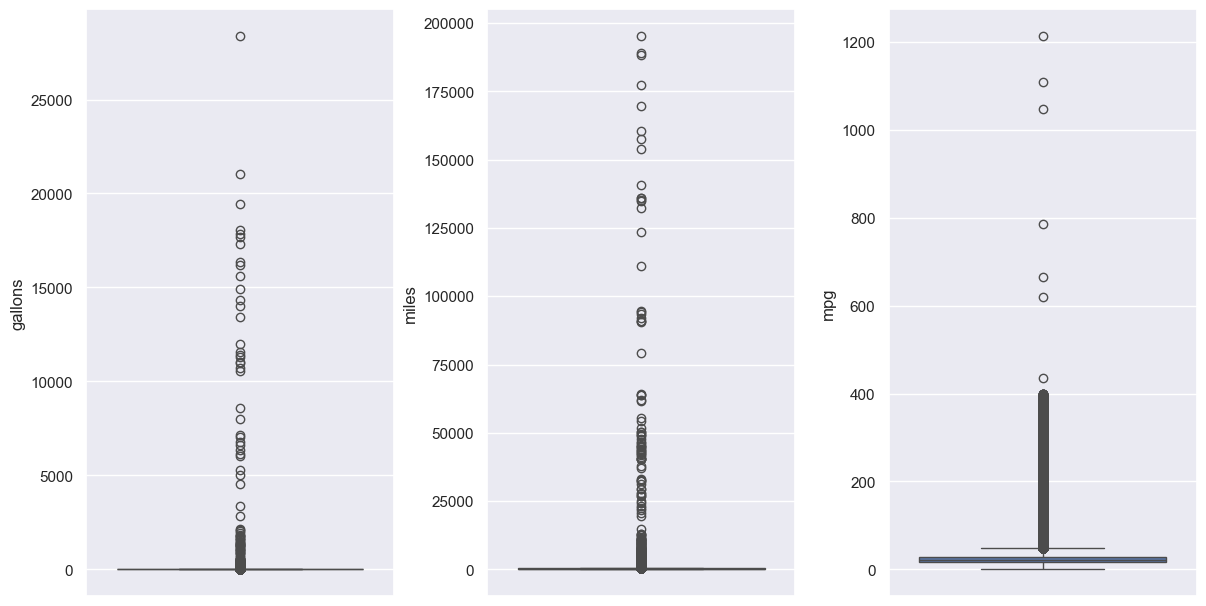

In [12]:
data_m_g_mpg = df[['gallons', 'miles', 'mpg']]
fig, axs = plt.subplots(ncols=3, nrows=1)
index = 0
axs = axs.flatten()
for k,v in data_m_g_mpg.items():
    sns.boxplot(y=k, data=data_m_g_mpg, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

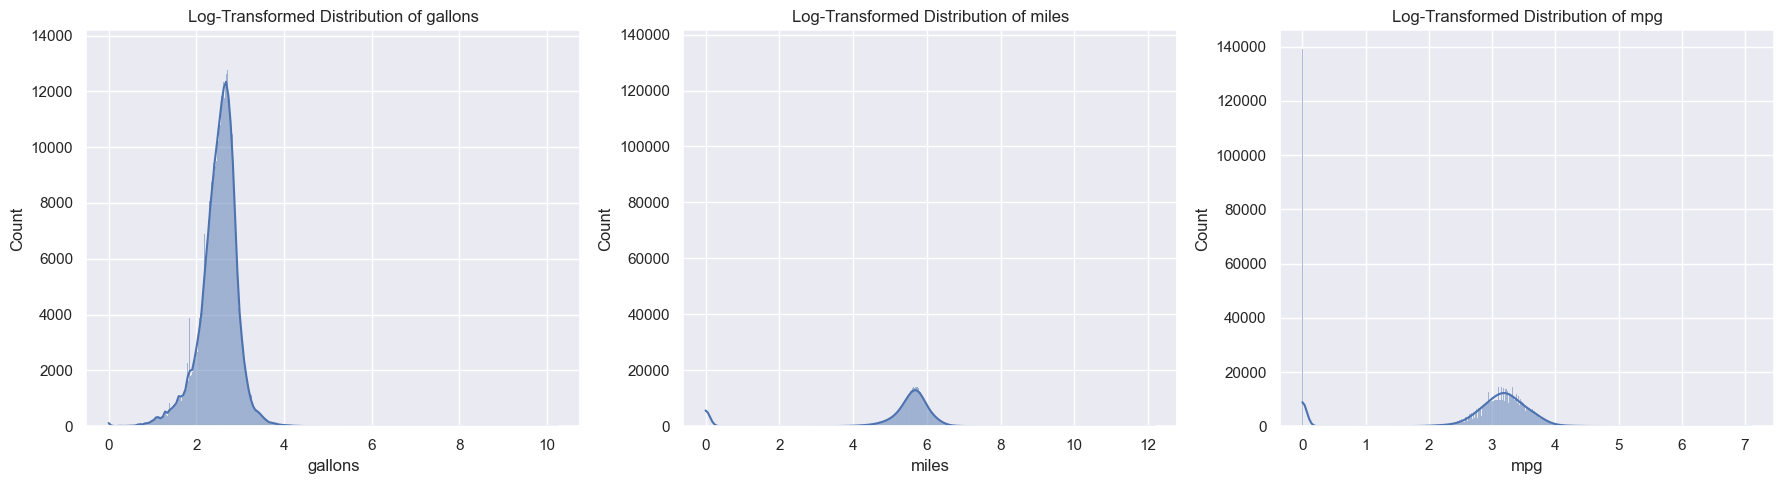

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

for ax, x in zip(axes, ['gallons', 'miles', 'mpg']):
    sns.histplot(np.log1p(df[x]), kde=True, ax=ax)
    ax.set_title(f'Log-Transformed Distribution of {x}')

plt.tight_layout()
plt.show()

 <center> REMEMBER TO COMMENT HERE ⁉️ </center>

5. Compute the statistical description of the columns: mean, standard deviation, max, min, most frequent, and quartiles. Do these results make
sense? [3]

In [14]:
# suppressing scientific notation when printing float values
pd.options.display.float_format = '{}'.format

df[['miles', 'gallons', 'mpg']].describe()

,miles,gallons,mpg
count,1100129.0,1100129.0,1100129.0
mean,269.45380130112017,12.79743047497157,22.163024699830657
std,725.7634370035393,74.48279111437775,15.744350144205049
min,0.0,0.0,0.0
25%,181.4,8.99,15.6
50%,267.0486,11.954,21.8
75%,342.7641,14.939,28.5
max,195321.2,28380.0,1214.3


These descriptions show that the mean for gallons is approximately 13 which makes sense, as I have mentioned that an average sized tank can hold between 12 to 18 gallons of fuel. There are clearly some extremes which do not make sense in this column. As we can see the maximum gallons is 28380, which seems highly unlikely for a car to be filled with that many gallons of fuel.

For mpg, the values make sense in relation to the values of miles and gallons. In reality, an average car (based in USA) gets an average of 25mpg. The average mpg here is 22 which is very close to 25, thus it makes sense in this aspect as well.

For miles, the average is 269 miles. This makes sense in relation to the average of 22mpg. If a car rides 269 miles based on 22mpg, on average they would consume 12-13 gallons of fuel. The maximum miles driven is 195321 miles. In relation to the extreme max value of gallons, this makes sense.

## 2 Feature engineering

#### 1. Create a new column with the currency. (Something to keep in mind is that the Swiss Franc has a period in the abbreviation).

In [15]:
df['currency'] = df['total_spent'].astype(str).str.extract(r'([^\d.,]+)')

#### 2. Create a new column containing the float value of the total spend and the cost per gallon. (Swiss Franc comment as above).

In [16]:
df["total_spent_float"] = df["total_spent"].str.extract(r"(\d*\.?\d+)", expand=True).astype(float)
df['cpg_float'] = df['cost_per_gallon'].str.extract(r"(\d*\.?\d+)", expand=True).astype(float)

#### 3. Car make, model, year, User ID: use the url (the last value in the URL is the user ID)


In [17]:
print(df['user_url'].head(10))

df['car_make'] = df['user_url'].str.split('/').str[3]
df['car_model'] = df['user_url'].str.split('/').str[4]
df['car_year'] = pd.to_numeric(df['user_url'].str.split('/').str[-2], errors='coerce')
df['user_id'] = df['user_url'].str.split('/').str[-1]


df.loc[(df['car_year'] < 1800) | (df['car_year'] > datetime.datetime.now().year), 'car_year'] = np.nan


0    https://www.somewebsite.com/suzuki/swift/2015/...
1       https://www.somewebsite.com/bmw/x3/2009/461150
2    https://www.somewebsite.com/mercedes-benz/e300...
3     https://www.somewebsite.com/bmw/320d/2010/247233
4    https://www.somewebsite.com/honda/passport/201...
5    https://www.somewebsite.com/volkswagen/passat/...
6    https://www.somewebsite.com/mazda/3_sport/2010...
7    https://www.somewebsite.com/subaru/forester/20...
8     https://www.somewebsite.com/kianival/2009/789684
9    https://www.somewebsite.com/lexus/rx350/2012/8...
Name: user_url, dtype: object


#### The data is given in imperial units, and in SA, we use proper measurement standards.

1. litres filled: use the gallons - consider whether to use UK or US gallons.

In [18]:
# Formula to convert to litres from gallons: gallons*3.785411784
# US Standard: 1 US liquid gallon = 3,78541 Liter
# UK Standard: 1 UK Gallon  = 4.54609 Litres

df['litres_filled'] = df['gallons']*3.785411784

2. km driven: use the miles driven to compute this

In [19]:
# Formula to convert from miles to km: miles*1.60934
df['km_driven'] = df['miles']*1.60934


3. litres per 100km: use the two new features to calculate this.

In [20]:
# Formula for litres per 100km: (litres_filled/km_driven)*100
df['litres_per_100km'] = (df['litres_filled']/df['km_driven'])*100

In [21]:
new_order = [
    'user_id', 'date_fueled_proxy', 'currency', 'total_spent_float', 'cpg_float', 
    'car_make', 'car_model', 'car_year', 'km_driven',
    'litres_filled', 'litres_per_100km',
    'cost_per_gallon', 'total_spent',  
    'date_fueled', 'date_captured', 'miles', 'odometer', 'gallons', 'mpg',
    'user_url',
]

df = df[new_order]
df.sample(5)


,user_id,date_fueled_proxy,currency,total_spent_float,cpg_float,car_make,car_model,car_year,km_driven,litres_filled,litres_per_100km,cost_per_gallon,total_spent,date_fueled,date_captured,miles,odometer,gallons,mpg,user_url
201107,574217,2021-08-29,S$,62.14,7.01,honda,vezel,2016.0,395.36864994199993,33.572817112296,8.4915223089188,S$7.01,S$62.14,2021-08-29,2021-08-29,245.67129999999997,21767.0,8.869,27.7,https://www.somewebsite.com/honda/vezel/2016/5...
1005168,1010793,2021-12-07,CA$,50.42,5.47,mitsubishi,outlander_phev,2019.0,2398.723844944,34.871213354207995,1.4537402222314628,CA$5.47,CA$50.42,2021-12-07,2021-12-07,1490.5016,11848.0,9.212,161.8,https://www.somewebsite.com/mitsubishi/outland...
694192,930517,2021-11-25,$,27.07,3.699,bmw,440i_xdrive,2018.0,312.05183067,27.697858023528,8.87604407385097,$3.699,$27.07,2021-11-25,2021-11-25,193.9005,56035.0,7.317,26.5,https://www.somewebsite.com/bmw/440i_xdrive/20...
901056,228051,2017-05-24,NZ$,79.98,4.77,fiat,punto,2007.0,1089.0403780000001,63.530565970872004,5.833628142194742,NZ$4.77,NZ$79.98,2017-05-24,2017-05-24,676.7,NaN,16.783,40.3,https://www.somewebsite.com/fiat/punto/2007/22...
298019,1109875,2021-11-06,nan,NaN,NaN,subaru,forester,2013.0,NaN,NaN,NaN,NaN,NaN,NaT,2021-11-06,NaN,131562.0,NaN,NaN,https://www.somewebsite.com/subaru/forester/20...


## 3. Vehicle Exploration

#### 1. Plot the number of unique users per country (remember, we proxy this by currency).

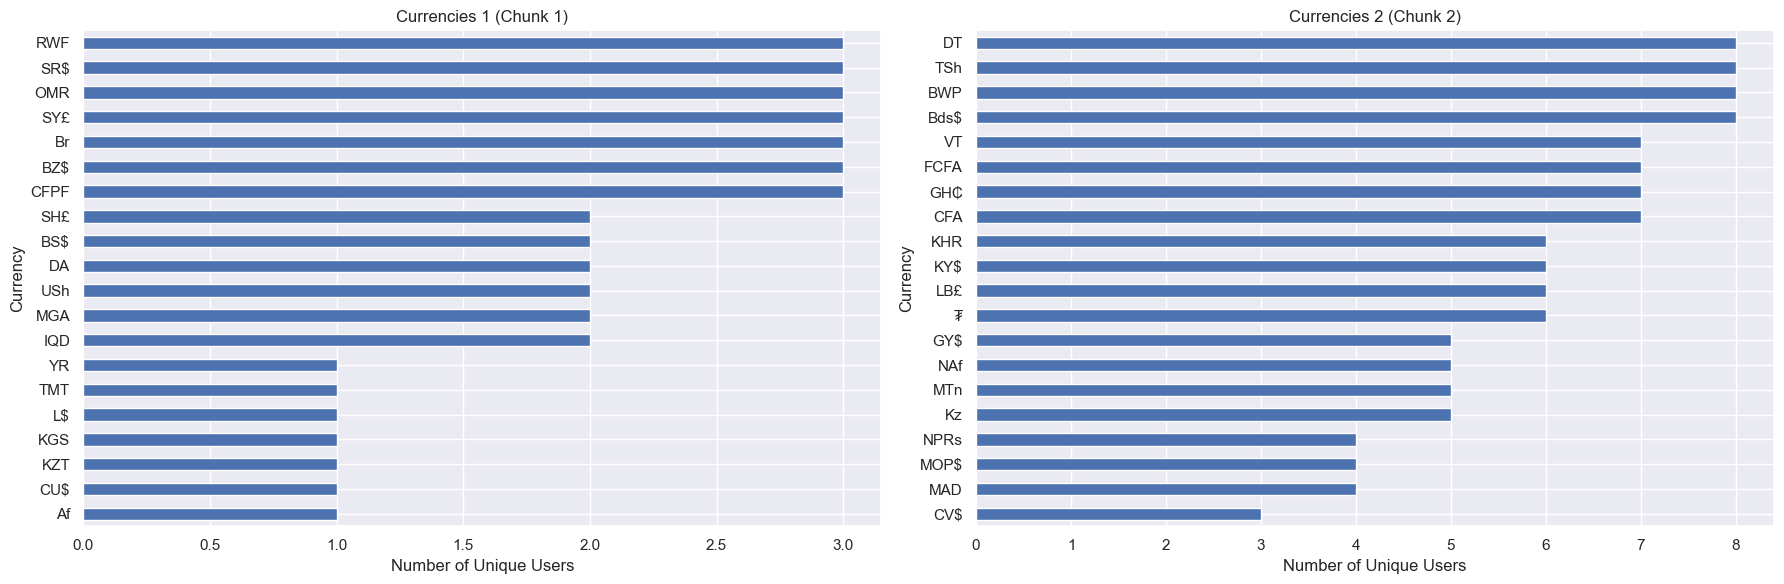

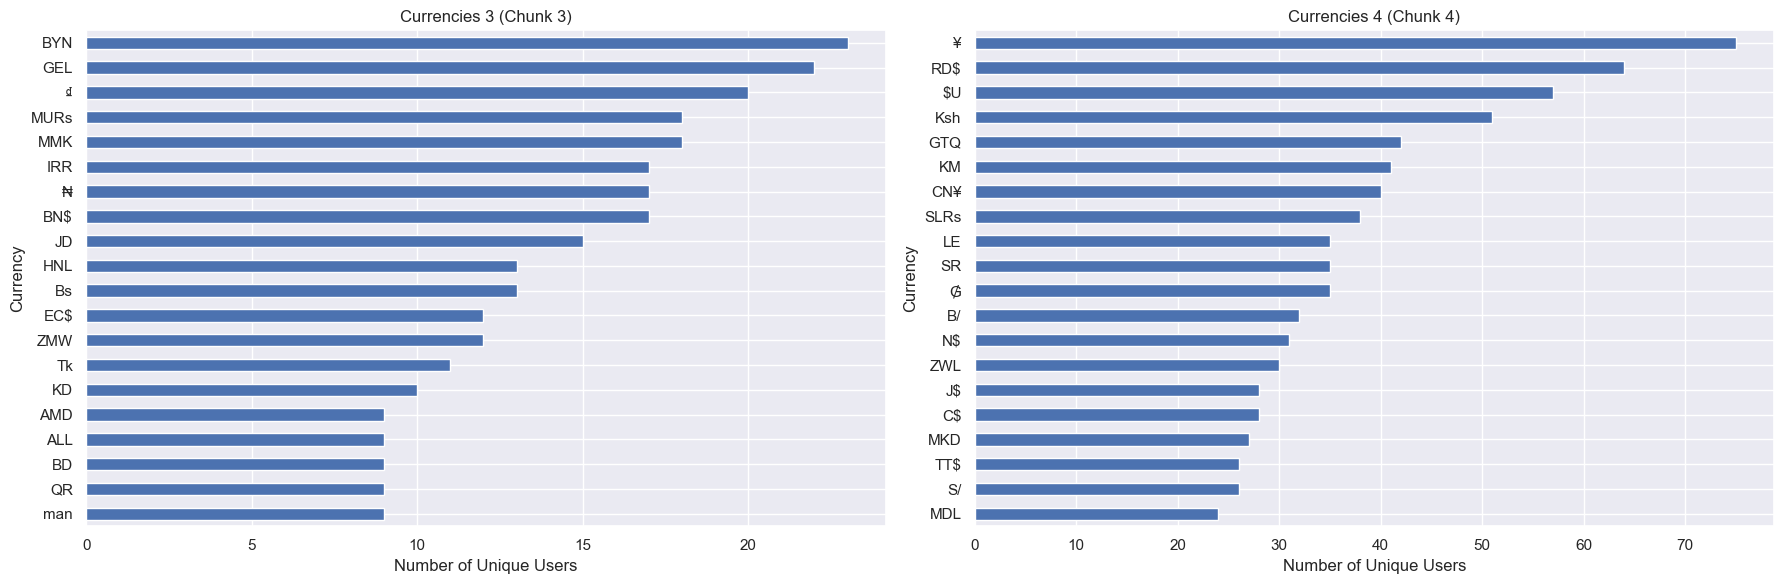

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_4060\2951253697.py:22: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


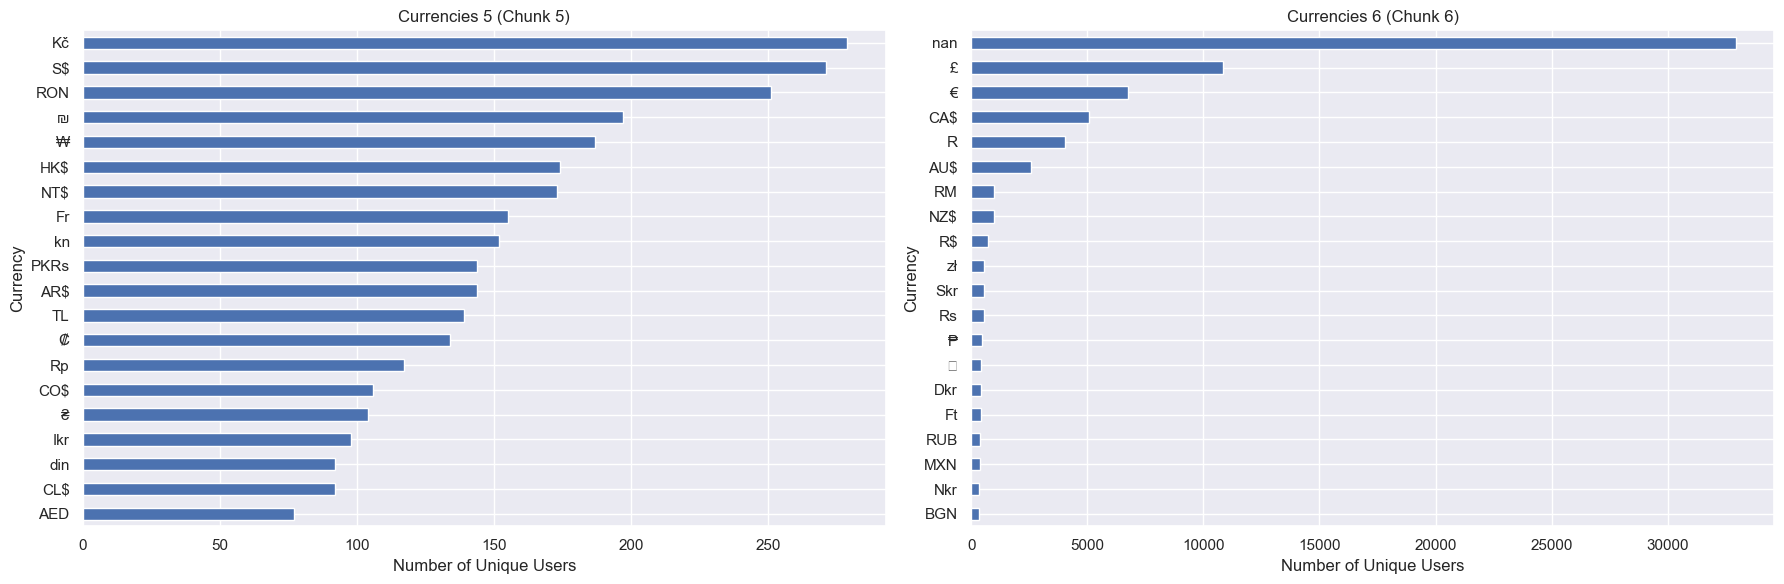

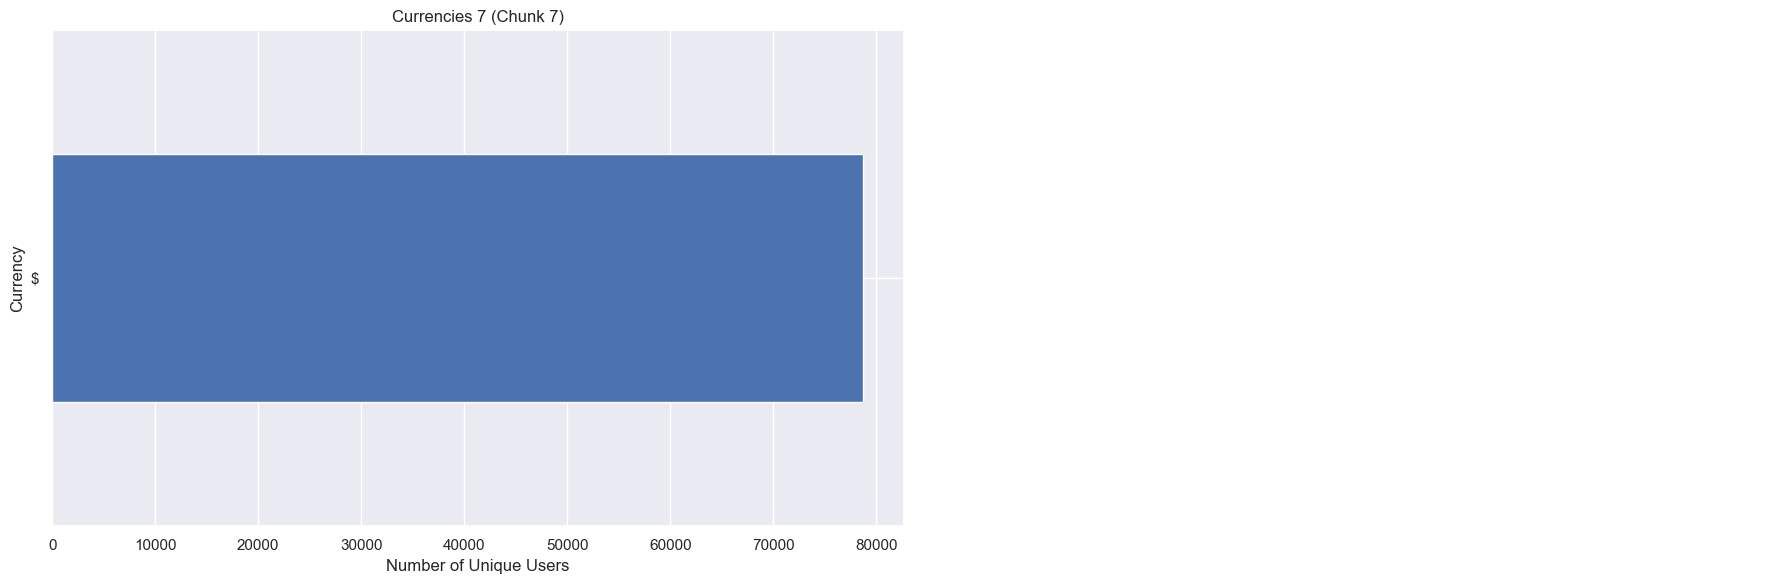

In [22]:
import matplotlib.pyplot as plt
import numpy as np

unique_users = df.groupby('currency')['user_id'].nunique().sort_values()

chunk_size = 20  # currencies per plot
chunks = [unique_users.iloc[i:i+chunk_size] for i in range(0, len(unique_users), chunk_size)]

# Plot 2 plots per row
for i in range(0, len(chunks), 2):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    for j in range(2):
        if i+j < len(chunks):
            chunks[i+j].plot(kind='barh', ax=axes[j])
            axes[j].set_xlabel('Number of Unique Users')
            axes[j].set_ylabel('Currency')
            axes[j].set_title(f'Currencies {i+j+1} (Chunk {i+j+1})')
        else:
            axes[j].axis('off')  # turn off empty subplot

    plt.tight_layout()
    plt.show()


#### 2. Look at the popularity of the app: plot the number of unique users per day.

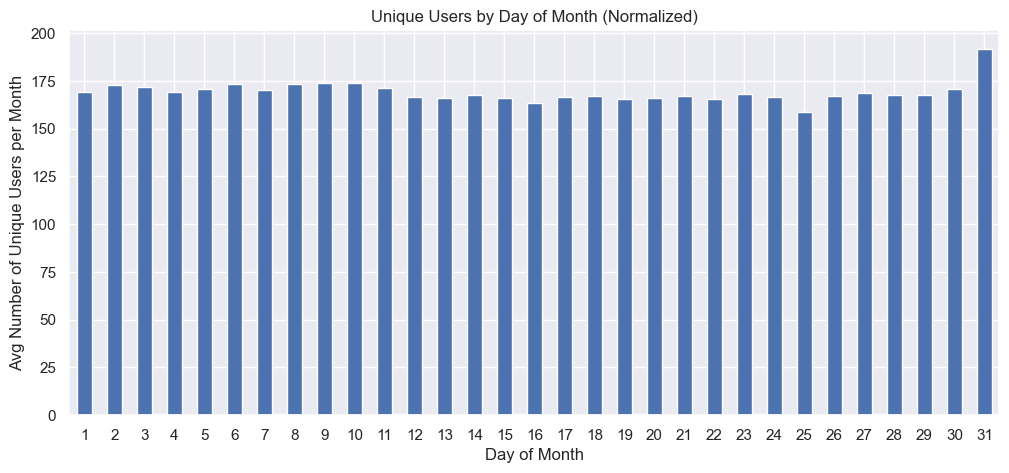

In [23]:
# Count unique users per day of month
users_per_day_of_month = df.groupby(df['date_captured'].dt.day)['user_id'].nunique()

# Count how many months have each day
days = df['date_captured'].dt.day
months = df['date_captured'].dt.month
years = df['date_captured'].dt.year
month_day_counts = df.groupby([years, months])['date_captured'].apply(lambda x: x.dt.day.unique())
day_month_counts = pd.Series([day for days_in_month in month_day_counts for day in days_in_month]).value_counts().sort_index()

# Normalize users per day by number of months with that day
normalized_users = users_per_day_of_month / day_month_counts

# Plot
plt.figure(figsize=(12,5))
normalized_users.plot(kind='bar')
plt.xlabel('Day of Month')
plt.ylabel('Avg Number of Unique Users per Month')
plt.title('Unique Users by Day of Month (Normalized)')
plt.xticks(rotation=0)
plt.show()

<span style="color:gold;font-weight:bold;">Improved above graph for fairness on days like 31st</span>

The number of unique users per day is generally lower for the 31st and the highest from the 8th to the 10th

#### 3. Look at the distribution of age of the vehicles per country - look at the year of the vehicle. Remember to look at the date it was refuelled, not the current date.

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_4060\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


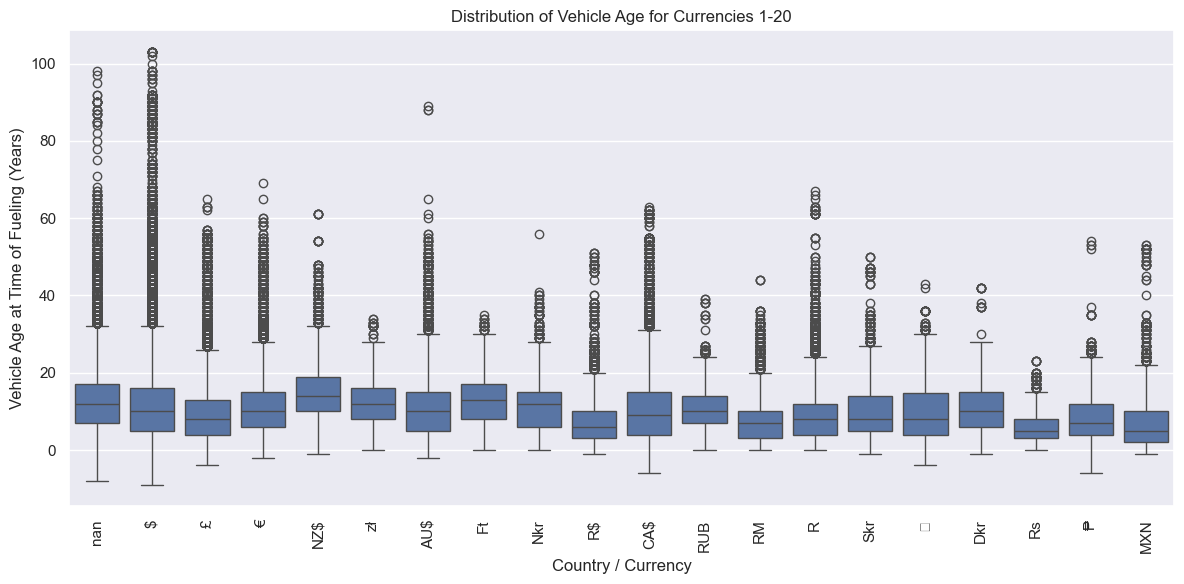

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_4060\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


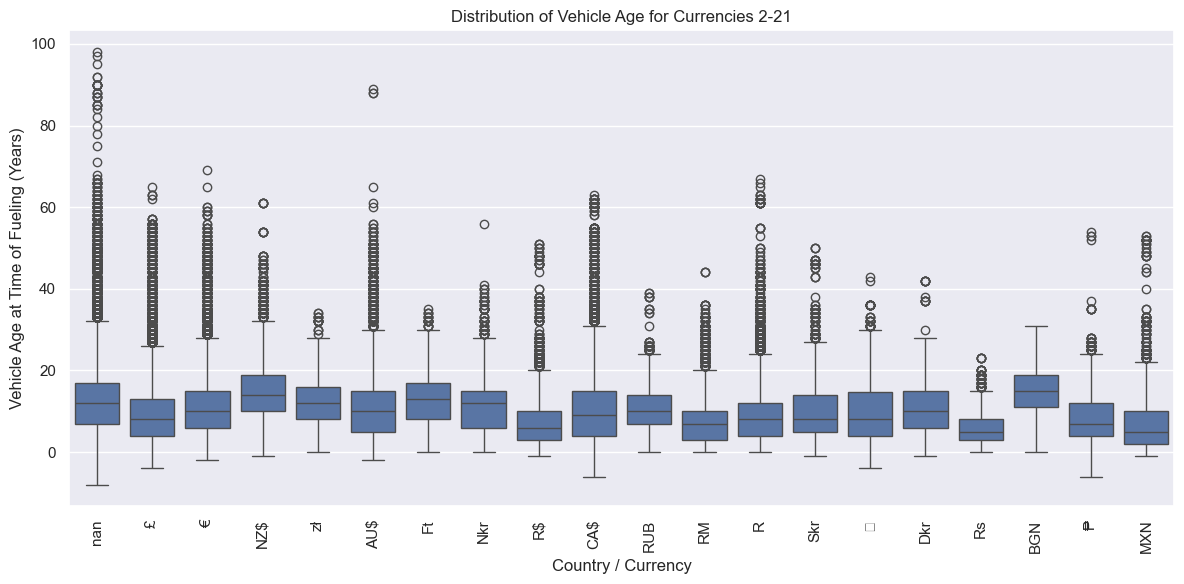

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_4060\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


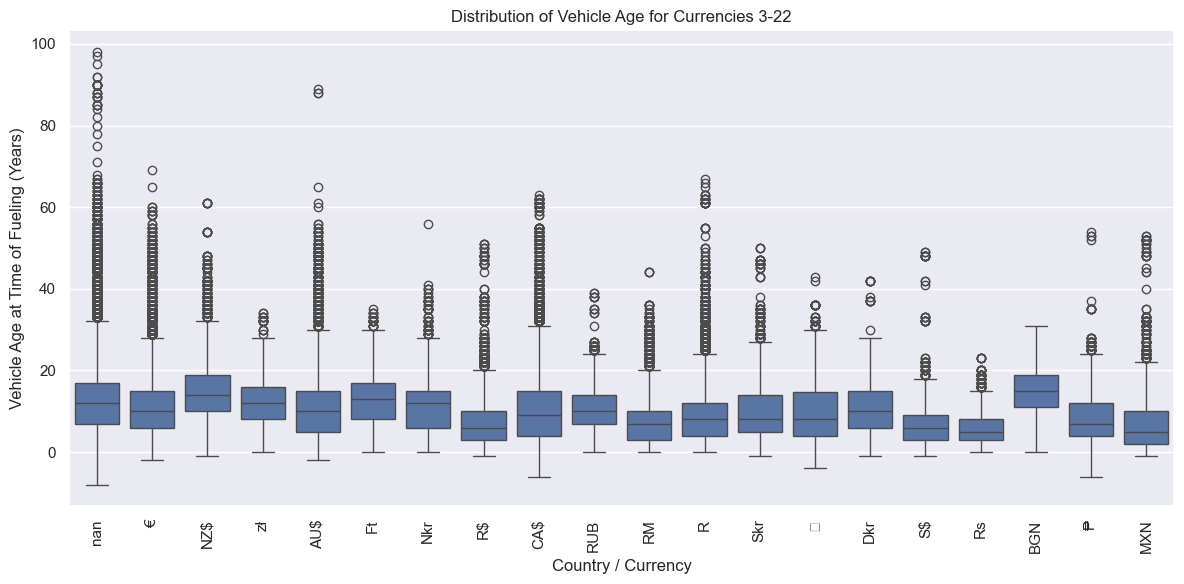

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_4060\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


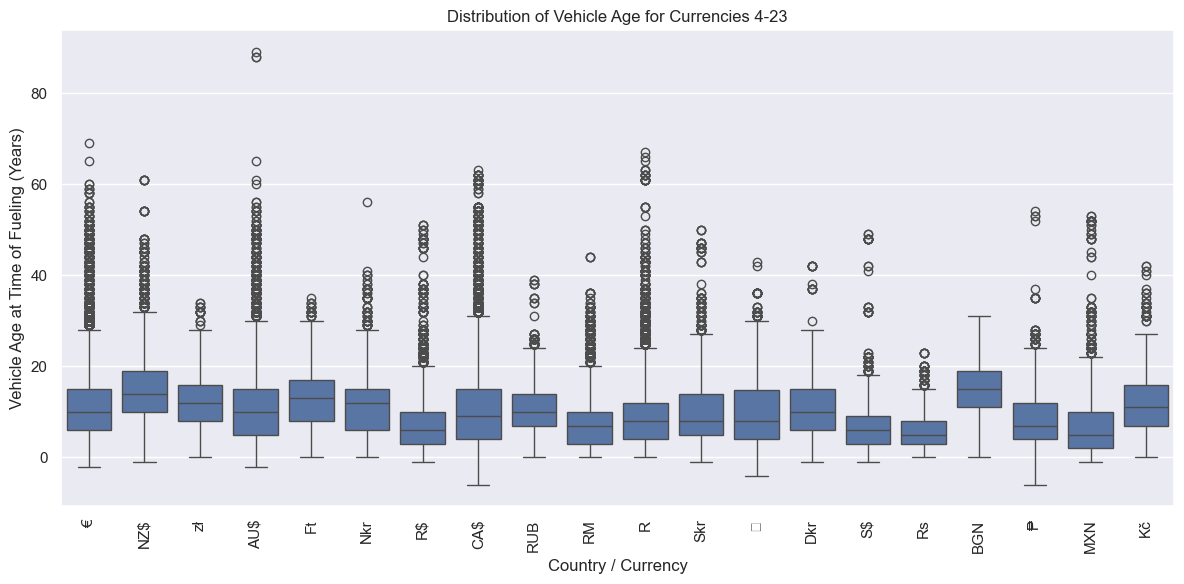

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_4060\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


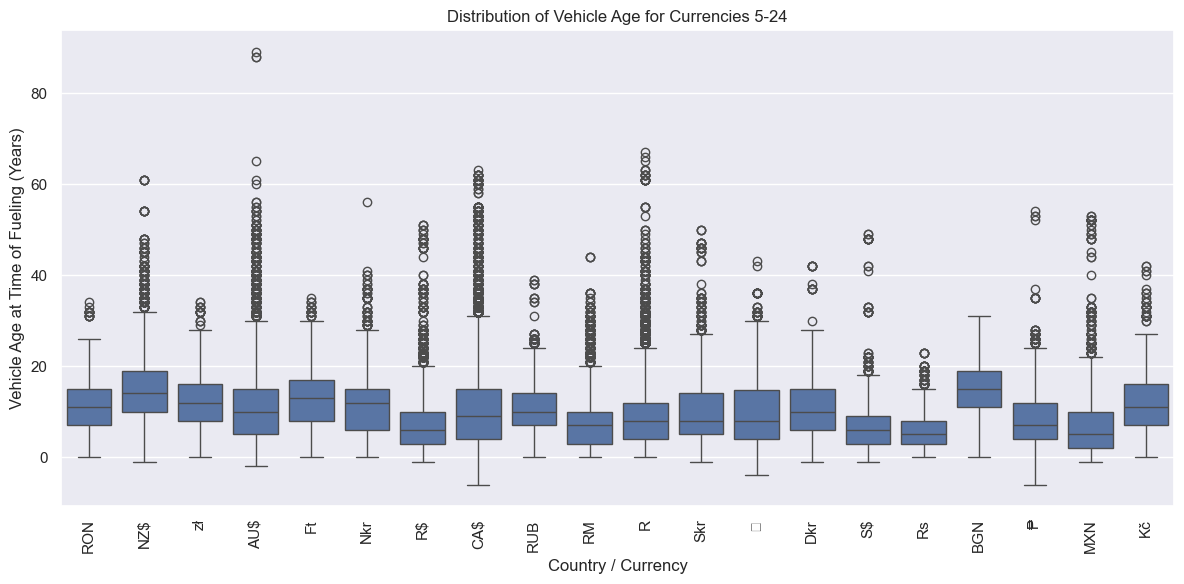

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_4060\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


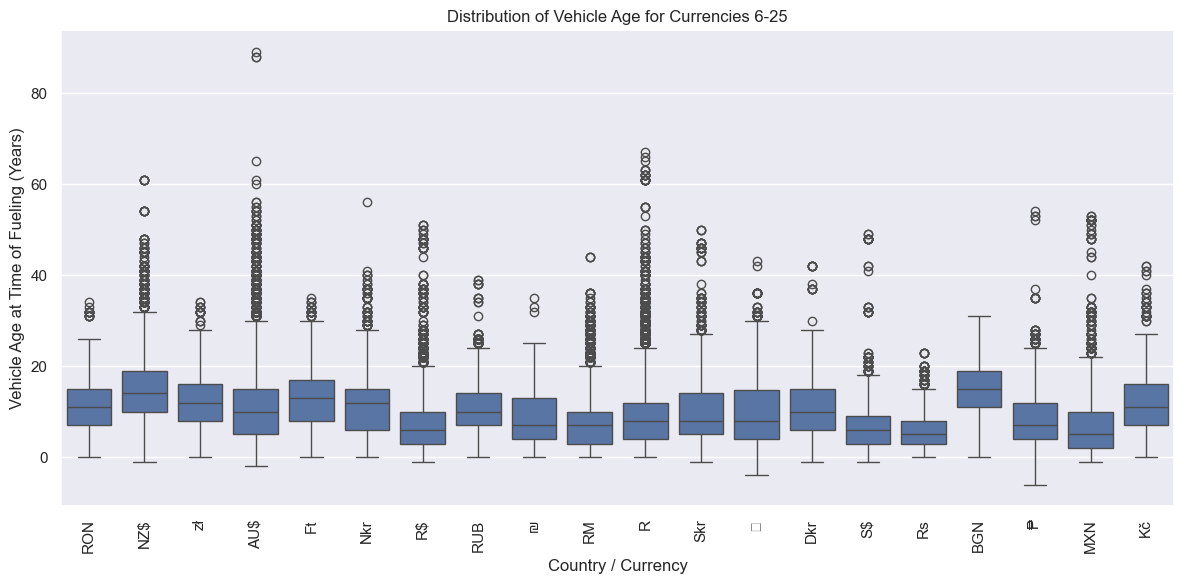

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_4060\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


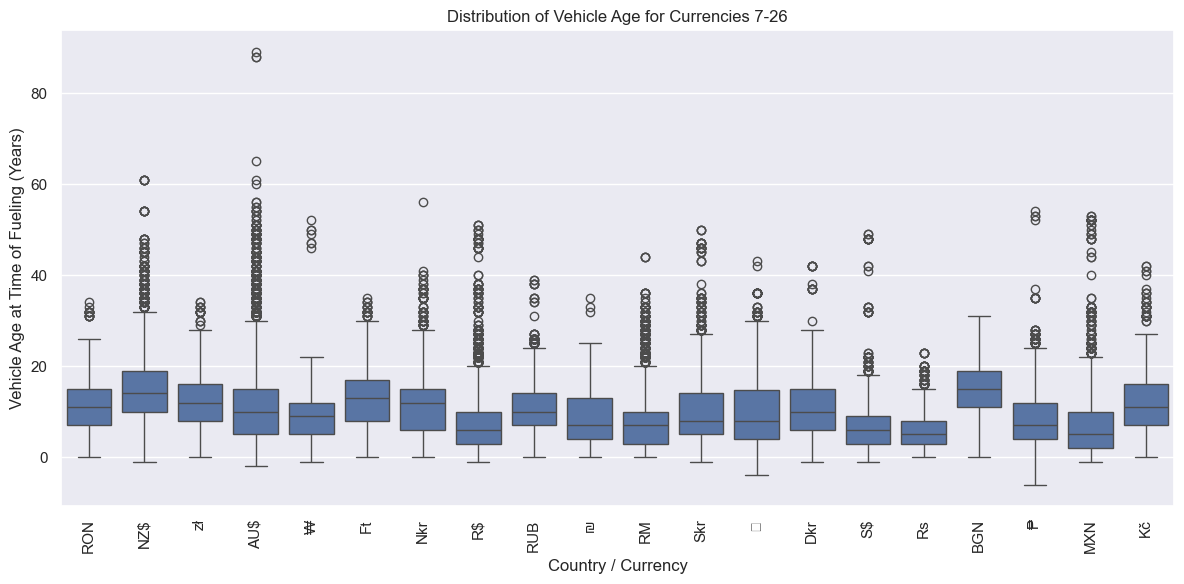

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_4060\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


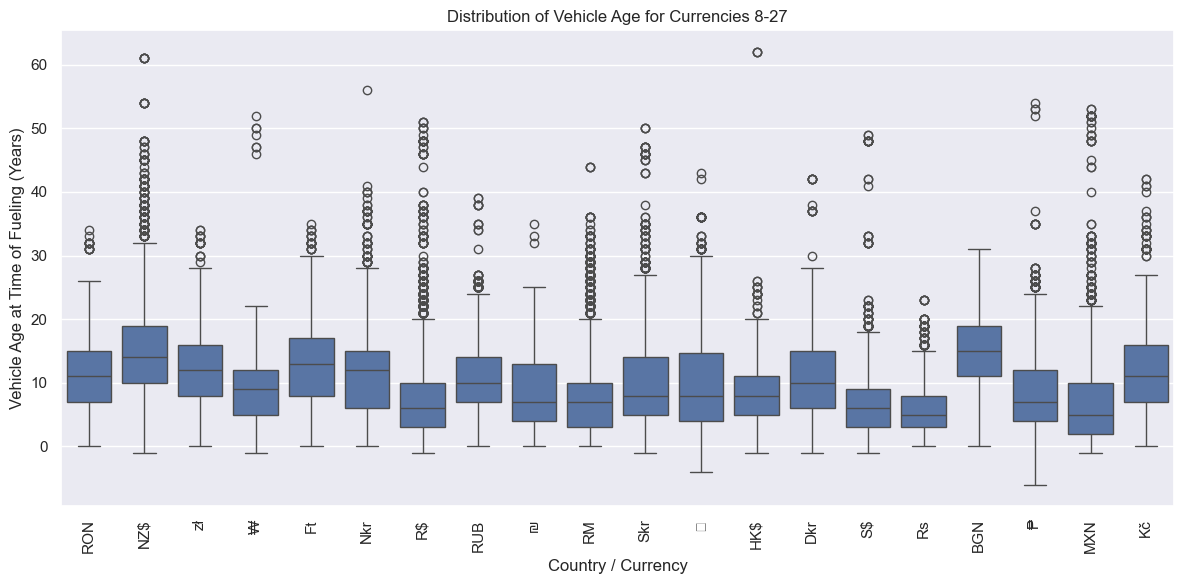

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_4060\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


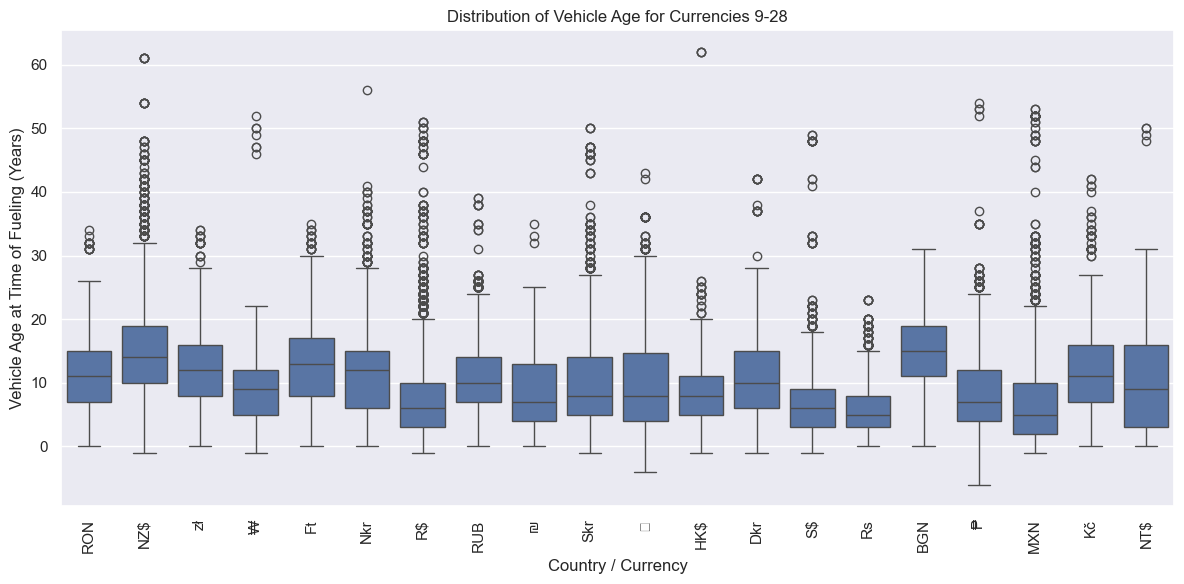

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_4060\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


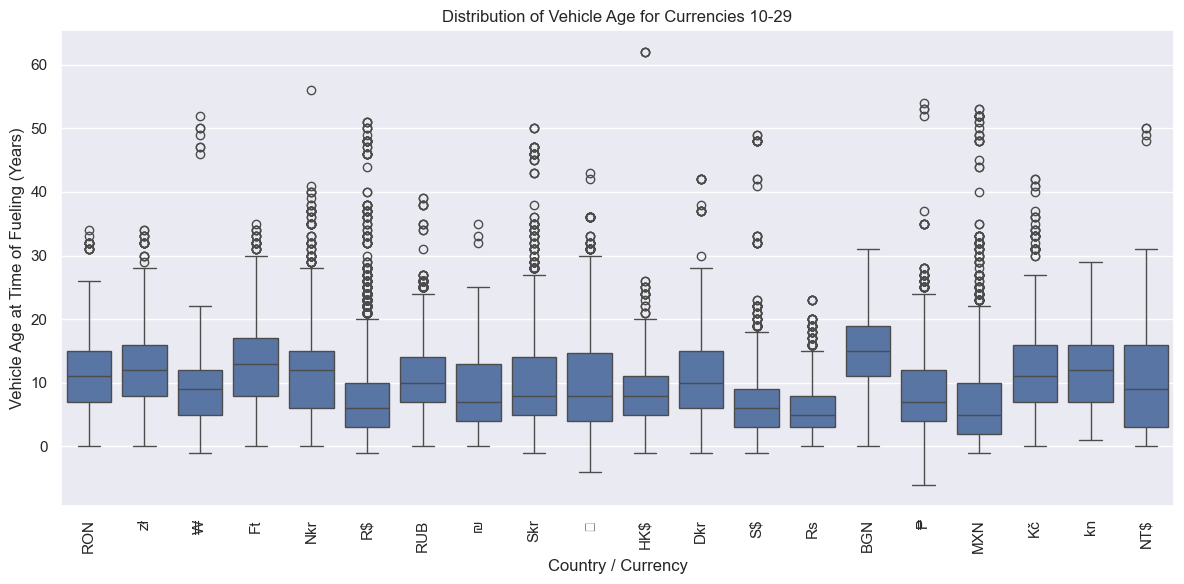

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_4060\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


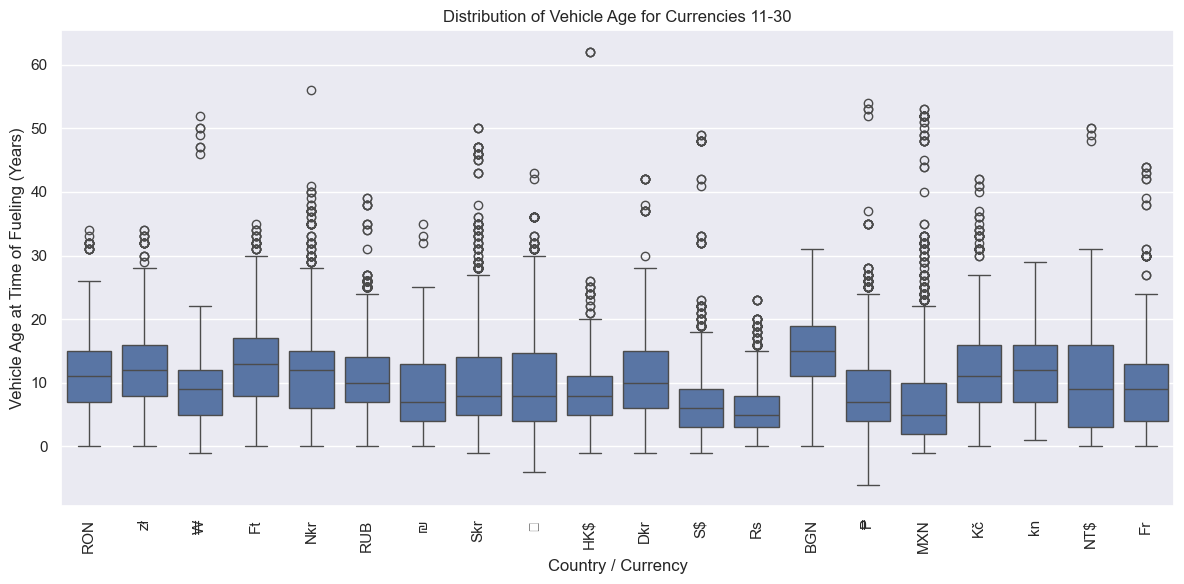

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_4060\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


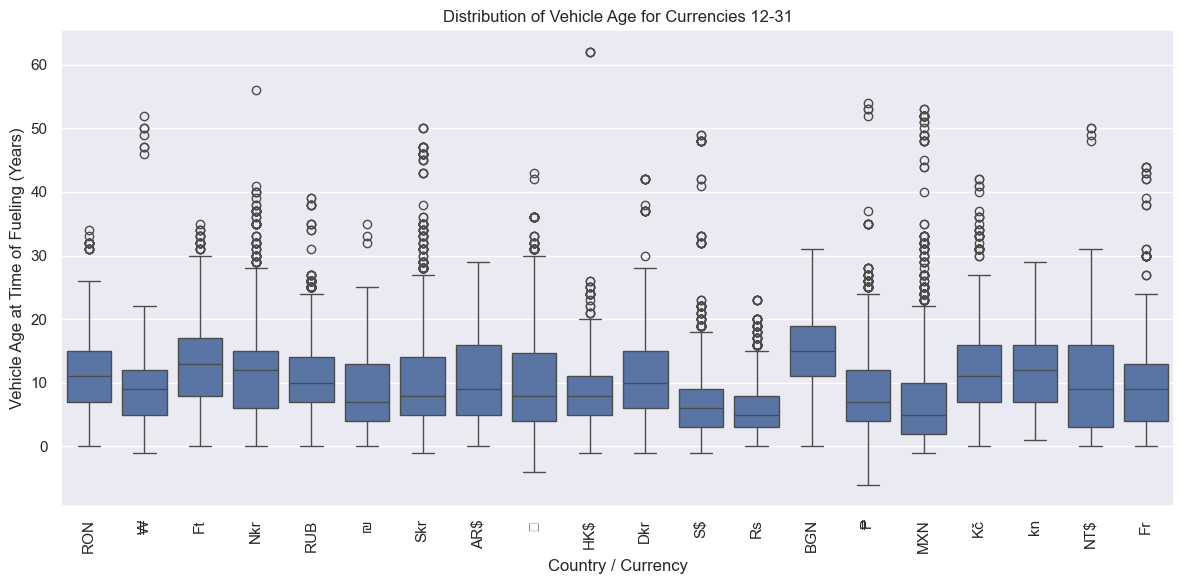

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_4060\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


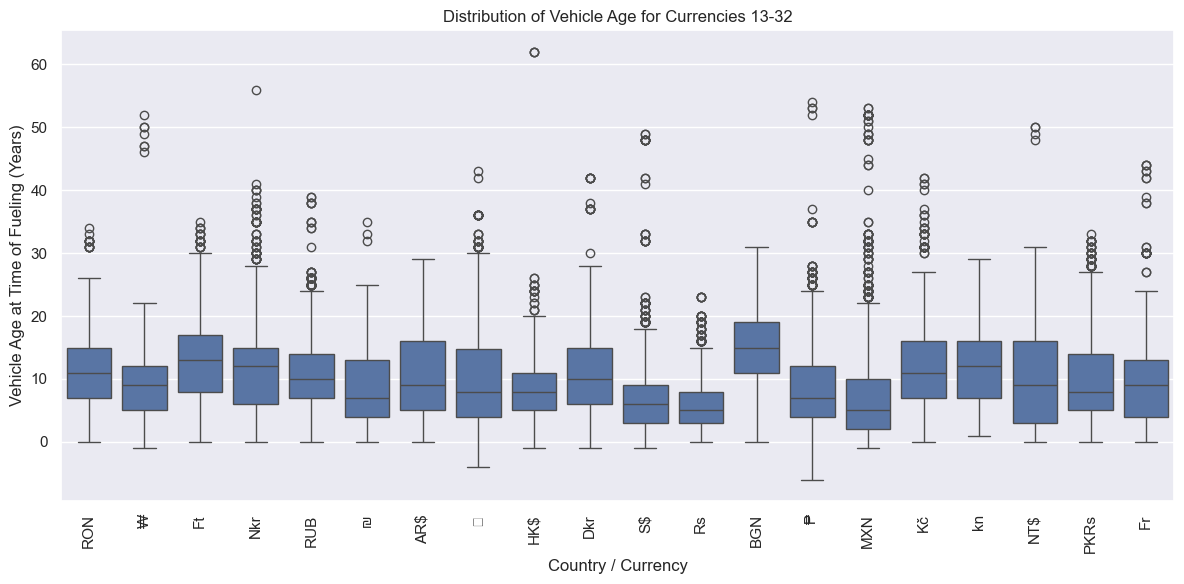

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_4060\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


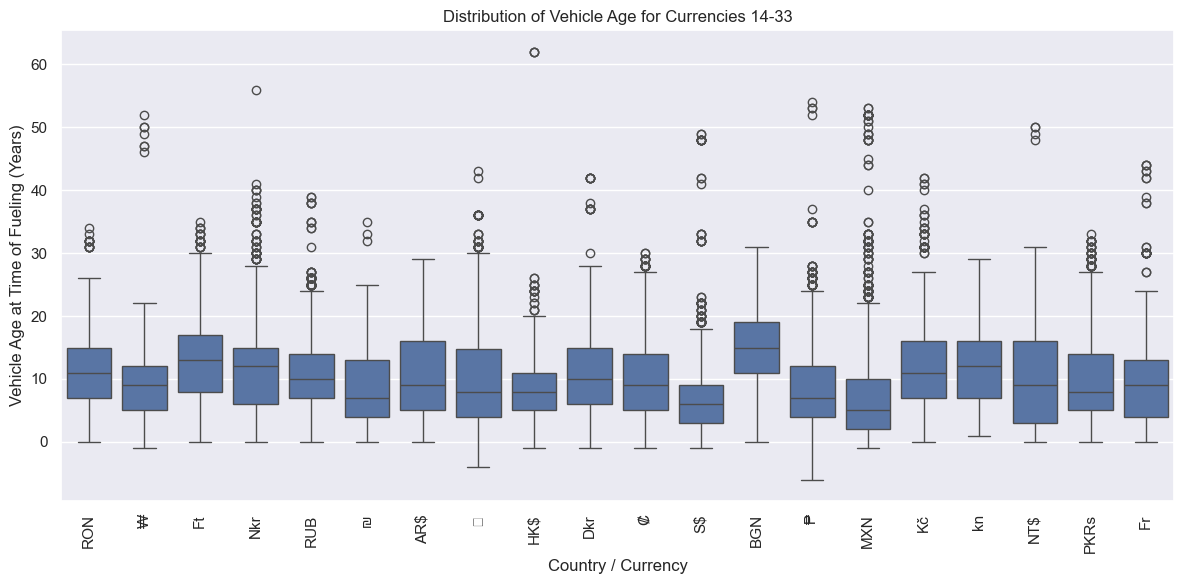

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_4060\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


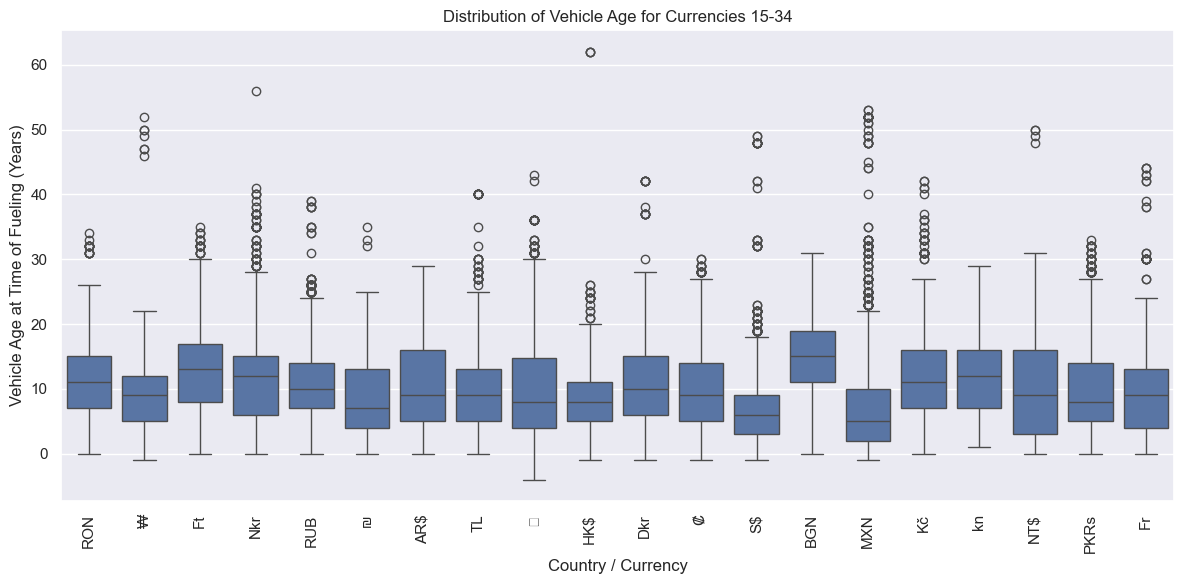

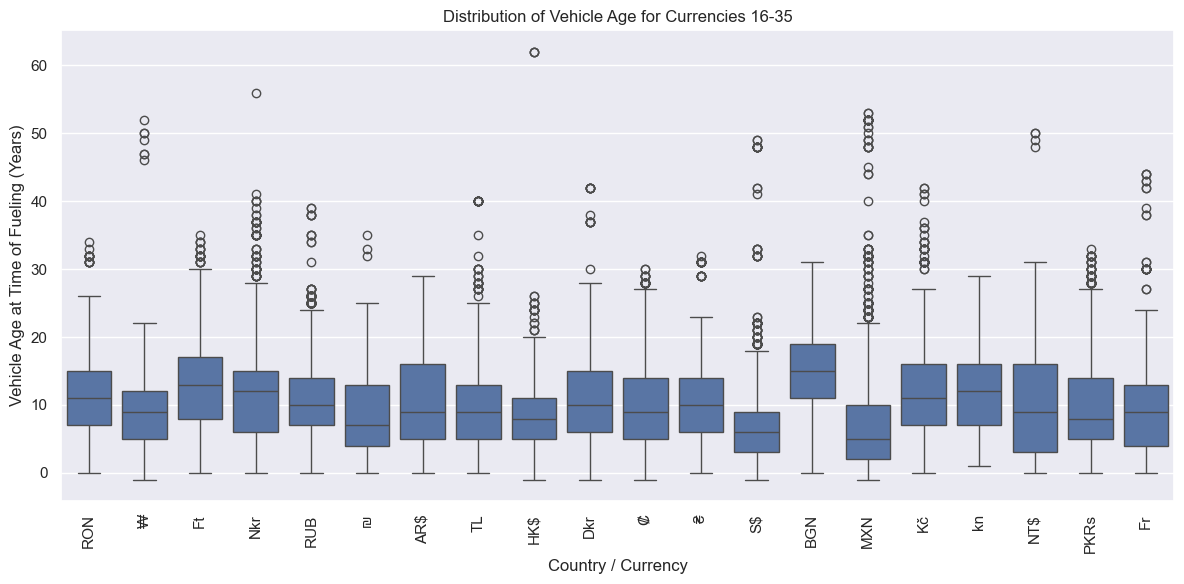

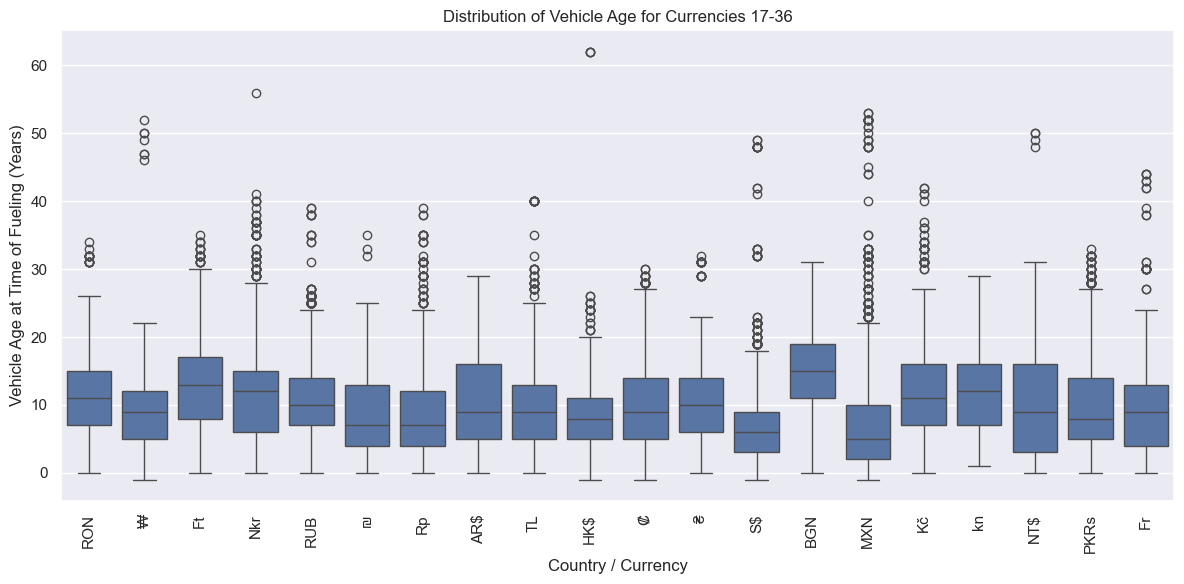

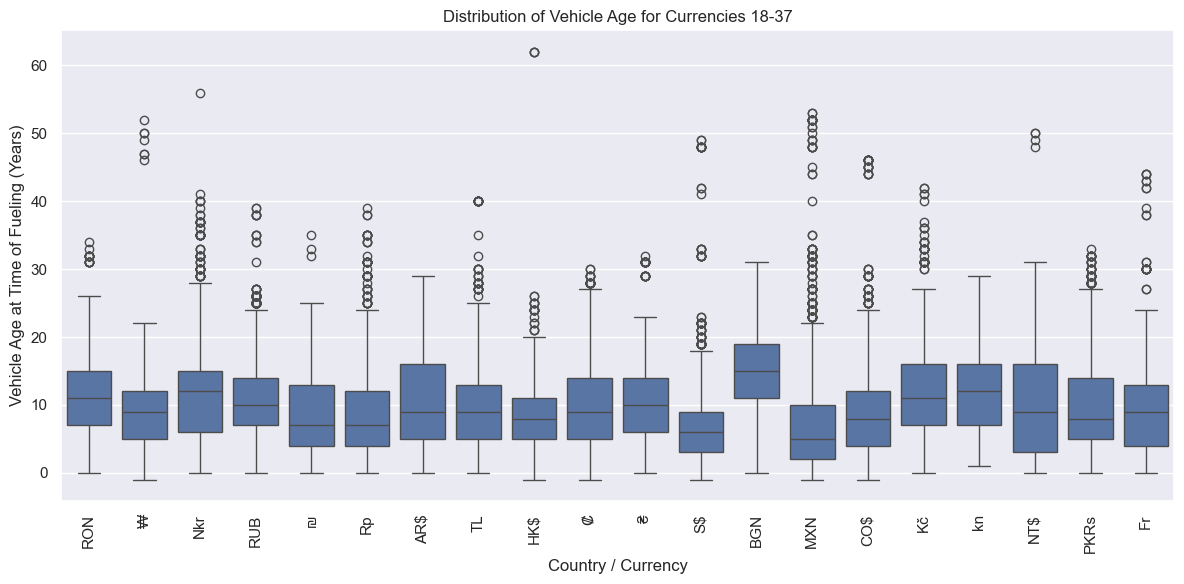

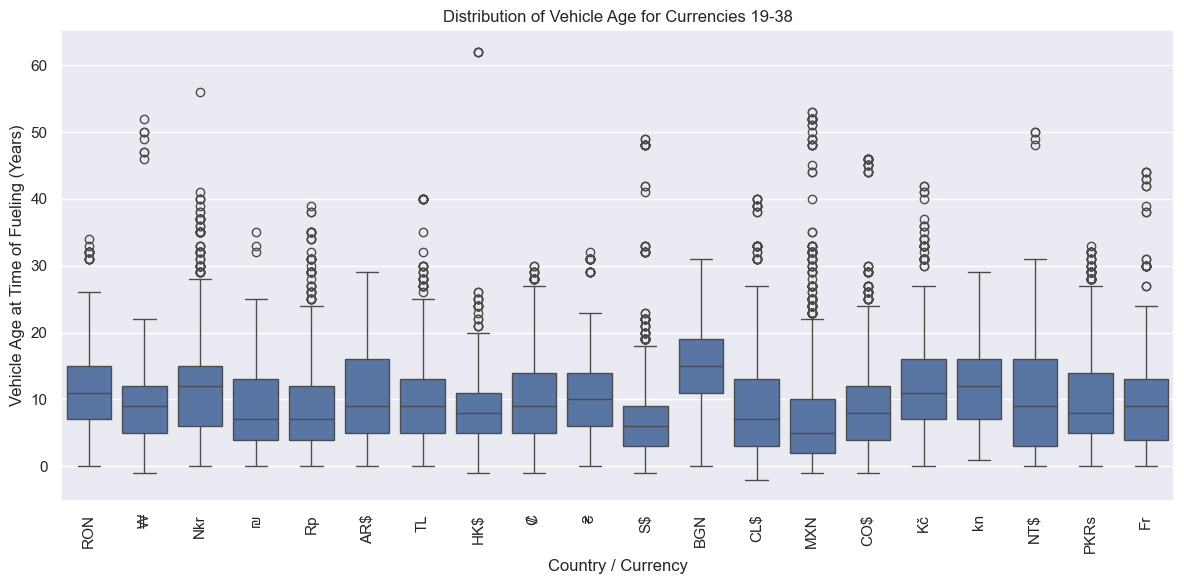

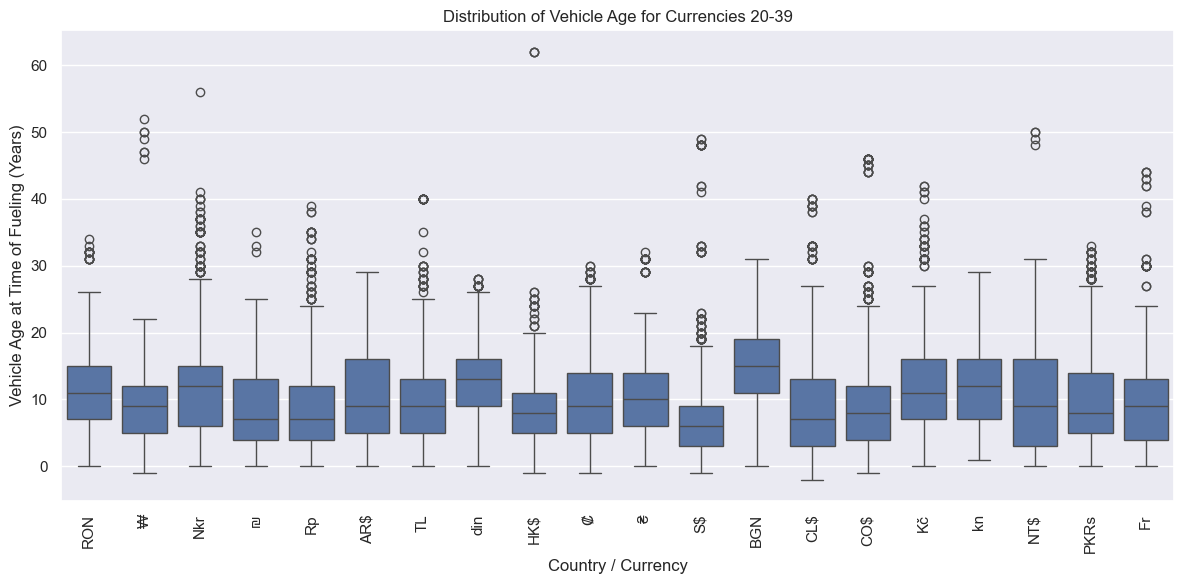

In [24]:
# Get unique currencies sorted by number of entries
df['vehicle_age'] = df['date_fueled_proxy'].dt.year - df['car_year']
currencies_sorted = df['currency'].value_counts().index

chunk_size = 20
for i in range(0, 20):
    chunk = currencies_sorted[i:i+chunk_size]
    plt.figure(figsize=(12,6))
    sns.boxplot(x='currency', y='vehicle_age', data=df[df['currency'].isin(chunk)])
    plt.xticks(rotation=90)
    plt.ylabel('Vehicle Age at Time of Fueling (Years)')
    plt.xlabel('Country / Currency')
    plt.title(f'Distribution of Vehicle Age for Currencies {i+1}-{i+len(chunk)}')
    plt.tight_layout()
    plt.show()

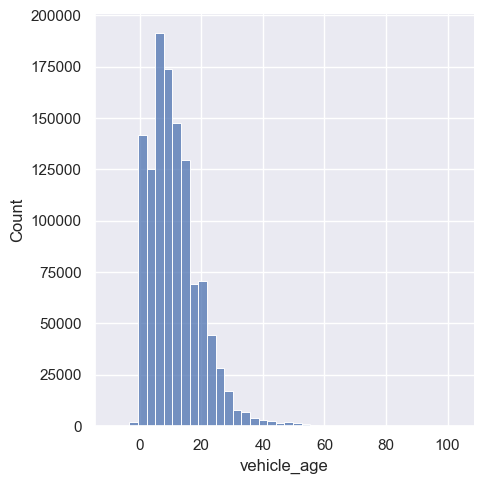

In [25]:
sns.displot(data=df, x= df['vehicle_age'], bins=40)

#### 4. Which makes and models of vehicles are the most popular?

In [26]:
most_popular_vehicle = df.groupby(['car_make', 'car_model']).car_make.count().reset_index(name='count')
most_popular_vehicle.nlargest(n=10, columns=['count'])

,car_make,car_model,count
692,honda,civic,8082
1937,toyota,4runner,7810
1972,toyota,corolla,7737
565,ford,f-150,7661
676,honda,accord,7633
627,ford,mustang,7520
642,ford,ranger,7424
2013,toyota,land_cruiser,7388
1964,toyota,camry,7316
888,jeep,wrangler,7061


In [27]:
df.sample(5)

,user_id,date_fueled_proxy,currency,total_spent_float,cpg_float,car_make,car_model,car_year,km_driven,litres_filled,...,cost_per_gallon,total_spent,date_fueled,date_captured,miles,odometer,gallons,mpg,user_url,vehicle_age
1083464,955970,2021-10-25,$,33.0,3.199,hyundai,accent,2020.0,574.427519824,39.050307963744004,...,$3.199,$33.00,2021-10-25,2021-11-04,356.9336,20565.0,10.316,34.6,https://www.somewebsite.com/hyundai/accent/202...,1.0
502768,666678,2021-10-11,$,44.36,3.579,ford,f-350_super_duty,2016.0,0.0,46.916393650896,...,$3.579,$44.36,2021-10-11,2021-10-11,0.0,96931.0,12.394,0.0,https://www.somewebsite.com/ford/f-350_super_d...,5.0
1026188,746666,2019-07-20,$,1.0,91.6,jeep,patriot,2010.0,339.15713962,47.20408494648,...,$91.600,"$1,142.25",2019-07-20,2019-07-20,210.743,121380.0,12.47,16.9,https://www.somewebsite.com/jeep/patriot/2010/...,9.0
1067890,719160,2021-10-20,CA$,41.21,5.3,volkswagen,transporter,1977.0,309.30018113799997,29.454289091304,...,CA$5.30,CA$41.21,2021-10-20,2021-10-25,192.1907,103457.0,7.781,24.7,https://www.somewebsite.com/volkswagen/transpo...,44.0
975939,848430,2022-01-12,$,37.13,2.849,kia,optima,2011.0,446.72317214400005,49.331486369088,...,$2.849,$37.13,2022-01-12,2022-01-12,277.58160000000004,114115.0,13.032,21.3,https://www.somewebsite.com/kia/optima/2011/84...,11.0


## 4. Fuel Usage

#### 1. Identify the top 5 currencies by number of transactions.

In [28]:
# consistency reasons - cost per gallon is converted to cost per litre
# divide fuel price (U.S. gallon) by 3.785411784 to get cost per litre
df['cpl_float'] = df['cpg_float']/3.785411784

# top 5 currencies with most entries
# Replace the string 'nan' with real NaN
df['currency'] = df['currency'].replace('nan', np.nan)

# Now count top 5 currencies ignoring NaNs
top_currencies = df['currency'].value_counts(dropna=True).head(5).rename_axis('currency').reset_index(name='count')

df['currency'].value_counts().rename_axis('currency')[:5].reset_index(name='count')

,currency,count
0,$,741953
1,£,87587
2,€,59273
3,CA$,46848
4,R,36424


#### 2. For each of the top 5 currencies separately, remove outliers by considering the total spend, litres, cost per litre, gallons, etc.

In [29]:
top_currencies = ['$', '£', '€', 'CA$', 'R']
top_5_df = df[df['currency'].isin(top_currencies)]

def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

numeric_cols = ['total_spent_float', 'litres_filled', 'cpl_float', 'gallons', 'km_driven', 'mpg', 'litres_per_100km']

cleaned_dfs = []

for cur in top_currencies:
    temp_df = top_5_df[top_5_df['currency'] == cur]
    for col in numeric_cols:
        if col in temp_df.columns:
            temp_df = remove_outliers_iqr(temp_df, col)
    cleaned_dfs.append(temp_df)

# Combine back
cleaned_top5_df = pd.concat(cleaned_dfs)

<span style="color:yellow">Handling more outliers from relationships across columns</span>

In [30]:
# Remove rows where total_spent_float differs from (litres_filled * cpl_float) by more than 10%
diff = abs(cleaned_top5_df['total_spent_float'] - (cleaned_top5_df['litres_filled'] * cleaned_top5_df['cpl_float']))
threshold = 0.10 * (cleaned_top5_df['litres_filled'] * cleaned_top5_df['cpl_float'])
mask = diff <= threshold
filtered_top5_df = cleaned_top5_df[mask]

# Calculate percentage of deleted rows
deleted_rows = cleaned_top5_df.shape[0] - filtered_top5_df.shape[0]
deleted_percentage = deleted_rows / cleaned_top5_df.shape[0] * 100
print(f'Rows deleted due to >10% difference: {deleted_rows} ({deleted_percentage:.2f}%)')

#update cleaned to filtered
cleaned_top5_df = filtered_top5_df

Rows deleted due to >10% difference: 5530 (0.79%)


In [31]:
# Create vehicle column
cleaned_top5_df["vehicle"] = (
    cleaned_top5_df["car_make"].astype(str) + " " + cleaned_top5_df["car_model"].astype(str)
)

# Count vehicles per currency
vehicle_counts = cleaned_top5_df.groupby("currency")["vehicle"].value_counts().reset_index(name="count")

# Threshold: keep top 90% cumulative frequency per currency
def mark_rare(group, threshold=0.9):
    group = group.sort_values("count", ascending=False)
    group["cum_pct"] = group["count"].cumsum() / group["count"].sum()
    group["keep"] = group["cum_pct"] <= threshold
    return group

vehicle_thresholds = vehicle_counts.groupby("currency", group_keys=False).apply(mark_rare)

# Vehicles to keep
keep_set = set(
    zip(vehicle_thresholds.loc[vehicle_thresholds["keep"], "currency"],
        vehicle_thresholds.loc[vehicle_thresholds["keep"], "vehicle"])
)

# Filter rows
cleaned_top5_df = cleaned_top5_df[
    cleaned_top5_df.apply(lambda r: (r["currency"], r["vehicle"]) in keep_set, axis=1)
]


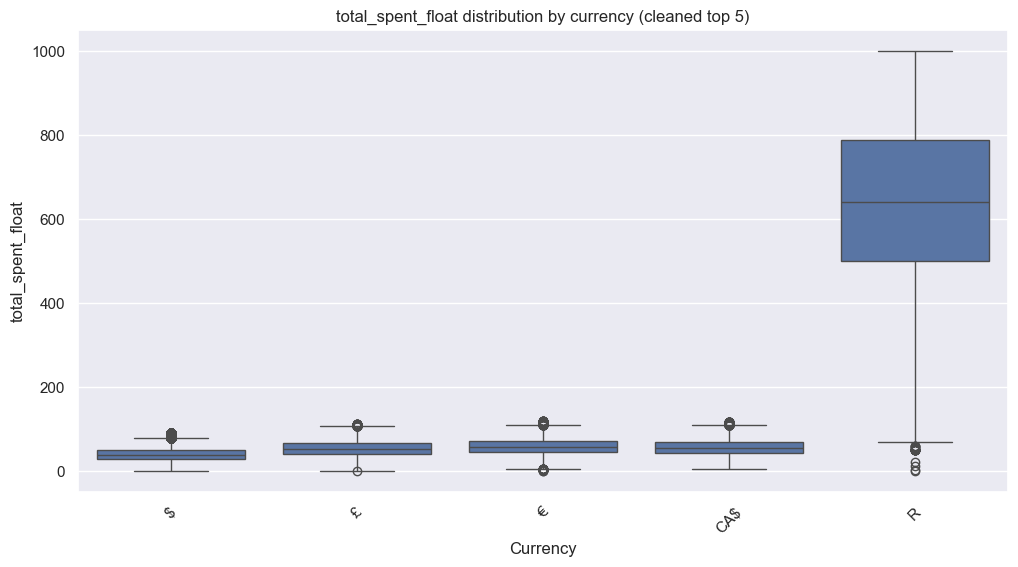

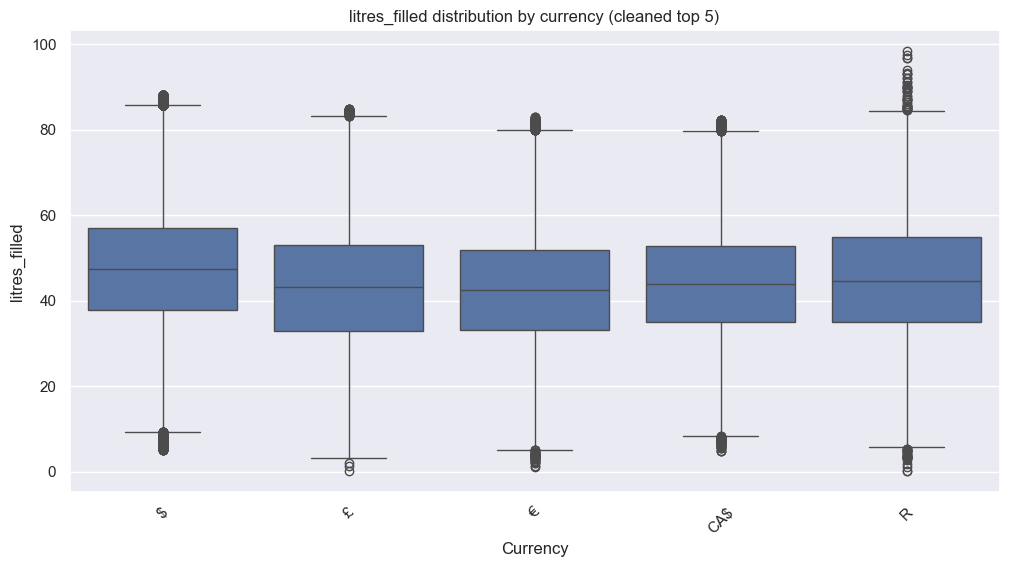

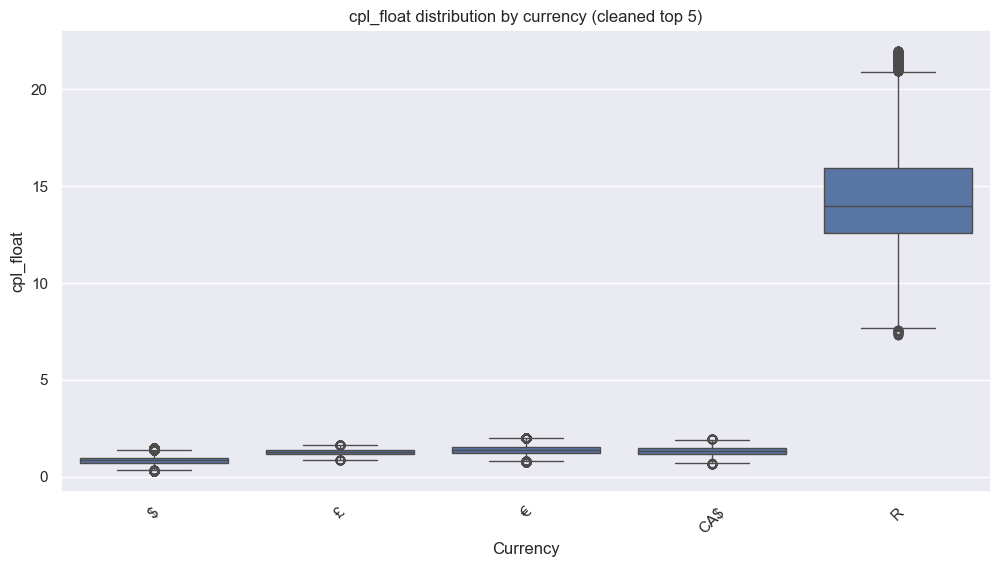

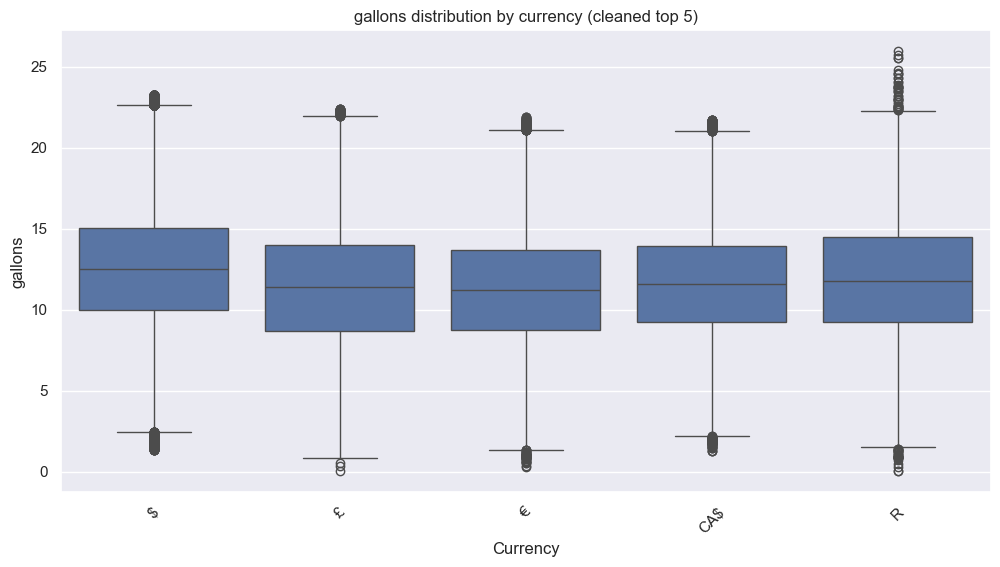

In [32]:
import seaborn as sns

numeric_cols = ['total_spent_float', 'litres_filled', 'cpl_float', 'gallons']

for col in numeric_cols:
    plt.figure(figsize=(12,6))
    sns.boxplot(x='currency', y=col, data=cleaned_top5_df)
    plt.xticks(rotation=45)
    plt.title(f'{col} distribution by currency (cleaned top 5)')
    plt.ylabel(col)
    plt.xlabel('Currency')
    plt.show()

In [ ]:
# (optional) ⁉️
# for col in numeric_cols:
#     plt.figure(figsize=(12,6))
#     sns.histplot(data=cleaned_top5_df, x=col, hue='currency', element='step', stat='density', common_norm=False)
#     plt.title(f'{col} distribution by currency (cleaned top 5)')
#     plt.xlabel(col)
#     plt.ylabel('Density')
#     plt.show()

<b>Reasoning</b>

IQR method: Removes extreme outliers while keeping most data.

Per currency: Prices and fuel amounts vary by country/currency, so outlier thresholds should be computed separately.

Columns considered:

- total_spent_float: extremely high fuel spends may be errors.
- litres_filled / gallons: unrealistic tank sizes.
- cpl_float: extreme fuel price entries.
- km_driven / mpg / litres_per_100km: extreme efficiency values.

#### 3. How many values have been removed after accounting for outliers?

In [33]:
# Original number of rows for top 5 currencies
original_count = top_5_df.shape[0]

# Number of rows after removing outliers
cleaned_count = cleaned_top5_df.shape[0]

# Number of rows removed
removed_count = original_count - cleaned_count

print(f'Original rows: {original_count}')
print(f'Rows after cleaning: {cleaned_count}')
print(f'Number of rows removed as outliers: {removed_count}')
print(f'Percentage of rows removed: {removed_count/original_count*100:.2f}%')

Original rows: 972085
Rows after cleaning: 626772
Number of rows removed as outliers: 345313
Percentage of rows removed: 35.52%


### 4.2. Fuel Efficiency


#### 1. Look at the difference in cost per litre per country for January 2022 - use the average currency conversion rate to Rands
https://www.nedbank.co.za/content/dam/nedbank/site-assets/AboutUs/Economics_Unit/Forecast_and_data/Daily_Rates/Monthly_Average_Exchange_Rates.pdf


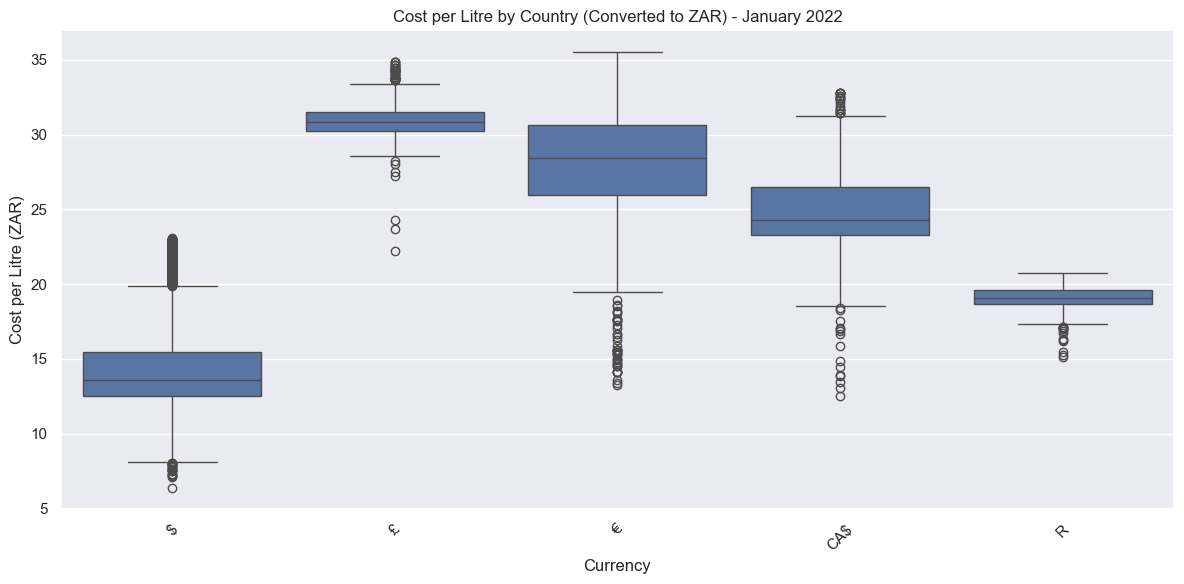

In [34]:
# Define exchange rates for January 2022
exchange_rates = {
    '$': 15.5972,  # USD to ZAR
    '€': 17.6922,  # EUR to ZAR
    '£': 21.1473,  # GBP to ZAR
    'CA$': 17.0088  # CAD to ZAR
}

# Filter for January 2022
jan_2022_df = cleaned_top5_df[
    (cleaned_top5_df['date_fueled_proxy'].dt.year == 2022) &
    (cleaned_top5_df['date_fueled_proxy'].dt.month == 1)
]

# Convert cost per litre to ZAR
jan_2022_df['cpl_zar'] = jan_2022_df.apply(
    lambda row: row['cpl_float'] * exchange_rates.get(row['currency'], 1)
    if row['currency'] in exchange_rates else row['cpl_float'],
    axis=1
)

# Plot the distribution for January 2022
plt.figure(figsize=(12, 6))
sns.boxplot(x='currency', y='cpl_zar', data=jan_2022_df)
plt.title('Cost per Litre by Country (Converted to ZAR) - January 2022')
plt.xlabel('Currency')
plt.ylabel('Cost per Litre (ZAR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




<span style="color:yellow">viewing plots from previous months could be helpful</span>

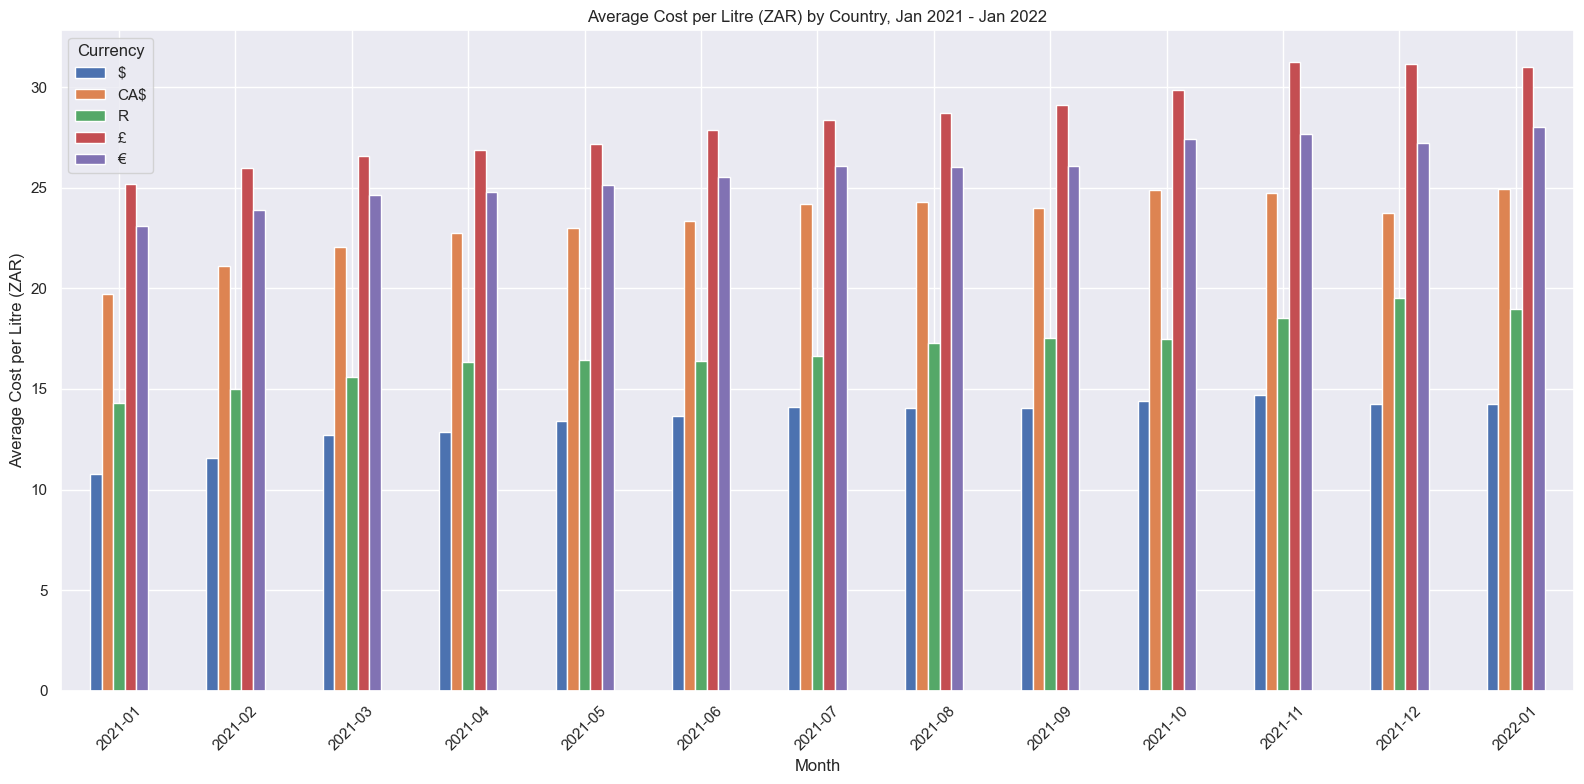

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for Jan 2021 to Jan 2022
mask = (cleaned_top5_df['date_fueled_proxy'] >= '2021-01-01') & (cleaned_top5_df['date_fueled_proxy'] <= '2022-01-31')
monthly_df = cleaned_top5_df[mask].copy()

# If not already present, convert cost per litre to ZAR
exchange_rates = {
    '$': 15.5972,  # USD to ZAR
    '€': 17.6922,  # EUR to ZAR
    '£': 21.1473,  # GBP to ZAR
    'CA$': 17.0088  # CAD to ZAR
}
if 'cpl_zar' not in monthly_df.columns:
    monthly_df['cpl_zar'] = monthly_df.apply(
        lambda row: row['cpl_float'] * exchange_rates.get(row['currency'], 1)
        if row['currency'] in exchange_rates else row['cpl_float'],
        axis=1
    )

# Extract year and month
monthly_df['year_month'] = monthly_df['date_fueled_proxy'].dt.to_period('M')

# Group by year_month and currency, calculate mean cost per litre in ZAR
monthly_avg = monthly_df.groupby(['year_month', 'currency'])['cpl_zar'].mean().reset_index()

# Pivot for plotting
pivot_df = monthly_avg.pivot(index='year_month', columns='currency', values='cpl_zar')

# Plot bar chart for each month
pivot_df.plot(kind='bar', figsize=(16,8))
plt.title('Average Cost per Litre (ZAR) by Country, Jan 2021 - Jan 2022')
plt.xlabel('Month')
plt.ylabel('Average Cost per Litre (ZAR)')
plt.xticks(rotation=45)
plt.legend(title='Currency')
plt.tight_layout()
plt.show()

#### 2. Looking at the odometer readings, find examples of where users have missed logging a fill-up. Give a basic rule for identifying this, and estimate how many there are in the dataset.

In [38]:
# Ensure date_fueled_proxy is datetime
cleaned_top5_df = cleaned_top5_df.sort_values(['user_id', 'date_fueled_proxy'])
# Compute difference in km driven between consecutive logs for each user
cleaned_top5_df['km_diff'] = cleaned_top5_df.groupby('user_id')['km_driven'].diff()
# km_diff is NaN for the first fill-up per user.
# Large values of km_diff may indicate missed fill-ups.

# Example: flag km_diff greater than 2 times the user's median distance per fill-up
cleaned_top5_df['median_km'] = cleaned_top5_df.groupby('user_id')['km_driven'].transform('median')
cleaned_top5_df['missed_fillup'] = cleaned_top5_df['km_diff'] > 2 * cleaned_top5_df['median_km']

# Show examples
missed_examples = cleaned_top5_df[cleaned_top5_df['missed_fillup']][['user_id', 'date_fueled_proxy', 'odometer', 'km_diff']]
print(missed_examples.head(10))


        user_id date_fueled_proxy  odometer            km_diff
651046   101552        2012-04-16       NaN           635.6893
965753  1021272        2020-01-19   77378.0       654.57651424
791260   102979        2013-03-19       NaN         534.783682
823523  1055904        2022-02-13  101370.0  399.1689454180001
522853  1071108        2022-04-03   70531.0      638.907658132
147672  1073763        2021-10-24  173213.0  727.8196697819999
298024  1078997        2021-07-13   21122.0       585.72573036
283858  1081729        2022-02-17  110430.0 329.91647027400006
15033   1096567        2021-10-19   97852.0      541.008126318
367316  1121890        2022-04-08   46697.0      408.049444472


Basic Rule

- Sort by user and fueling date.
- Compute km_diff between consecutive refuels.
- If km_diff > 1.5 × median km per fill-up for that user, flag as potential missed fill-up.
- Threshold can be adjusted based on typical driving patterns.
- This is a simple, heuristic approach; more advanced methods can consider MPG, fuel tank size, or expected distances.

#### 3. Plot the average distance (in km) per tank per country. Which country has the largest average distance? Provide some explanations for why this might be the case.

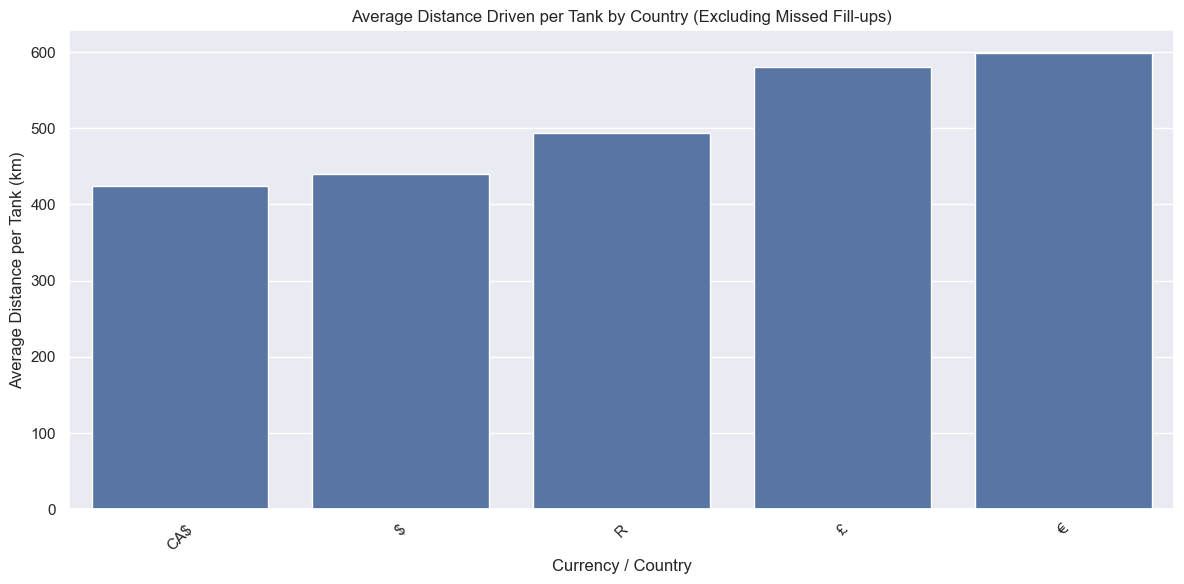

Country with largest average distance: € (598.5 km per tank)


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows flagged as missed fill-ups
cleaned_top5_df = cleaned_top5_df[~cleaned_top5_df['missed_fillup']]

# Group by currency and calculate mean km per tank
avg_distance_per_currency = cleaned_top5_df.groupby('currency')['km_driven'].mean().sort_values()

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=avg_distance_per_currency.index, y=avg_distance_per_currency.values)
plt.xlabel('Currency / Country')
plt.ylabel('Average Distance per Tank (km)')
plt.title('Average Distance Driven per Tank by Country (Excluding Missed Fill-ups)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify country with largest average distance
max_currency = avg_distance_per_currency.idxmax()
max_distance = avg_distance_per_currency.max()
print(f'Country with largest average distance: {max_currency} ({max_distance:.1f} km per tank)')


€. has the largest average distance. The reason for this might be that cars in other countries are simply not as fuel-efficient as those in

€.. These cars are designed to accommodate

€. gas prices, which are probably far higher than other countries gas prices. As a result, €. vehicles allow drivers to achieve greater miles per gallon (km per litre).

#### 4. Do newer vehicles drive further distances between fill-ups? Provide a plot to show this. 

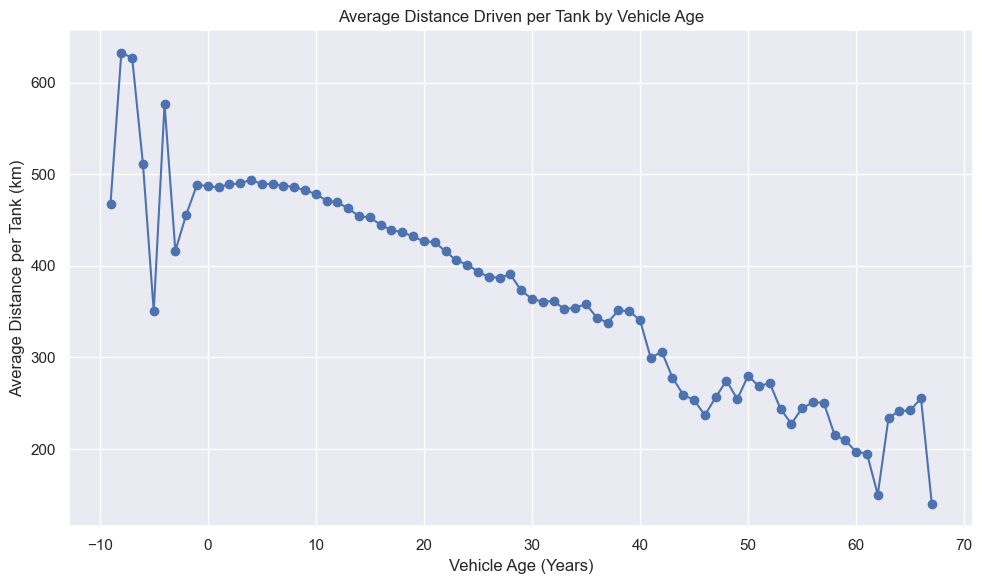

In [58]:
avg_distance_per_age = cleaned_top5_df.groupby('vehicle_age')['km_driven'].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_distance_per_age.index, avg_distance_per_age.values, marker='o')
plt.title('Average Distance Driven per Tank by Vehicle Age')
plt.xlabel('Vehicle Age (Years)')
plt.ylabel('Average Distance per Tank (km)')
plt.grid(True)
plt.tight_layout()
plt.show()


#### 5. Take the top 5 most popular vehicles in SA (ie, those with currency set to R). Compute their fuel efficiency and discuss whether these values are realistic.

Top 5 vehicles in SA: Index(['suzuki jimny', 'toyota hilux', 'mitsubishi pajero', 'volkswagen polo',
       'toyota fortuner'],
      dtype='object', name='vehicle')

 
  vehicle
mitsubishi pajero   12.545947390254506
toyota hilux         11.95873492773363
toyota fortuner     11.039257575046449
suzuki jimny         9.172396256598883
volkswagen polo      7.728291565001874
Name: litres_per_100km, dtype: float64


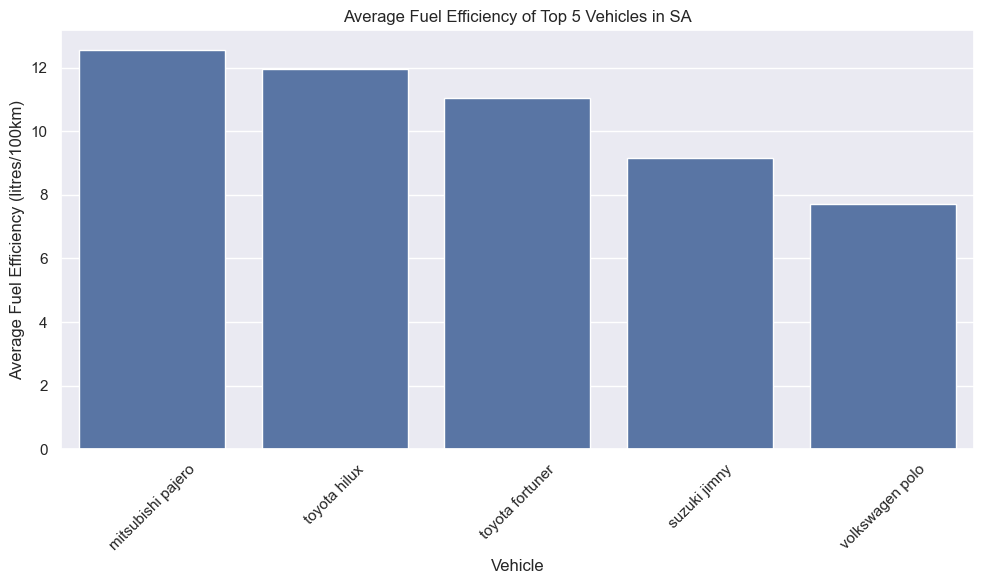

In [59]:
# Filter for South Africa
sa_df = cleaned_top5_df[cleaned_top5_df['currency'] == 'R']

# Count most popular vehicles
sa_df['vehicle'] = sa_df['car_make'] + ' ' + sa_df['car_model']
top5_vehicles = sa_df['vehicle'].value_counts().head(5).index
print("Top 5 vehicles in SA:", top5_vehicles)

# Filter only top 5 vehicles
top5_sa_df = sa_df[sa_df['vehicle'].isin(top5_vehicles)]

# Compute average fuel efficiency per vehicle
fuel_efficiency = top5_sa_df.groupby('vehicle')['litres_per_100km'].mean().sort_values(ascending=False)
print("\n \n ",fuel_efficiency)

plt.figure(figsize=(10,6))
sns.barplot(x=fuel_efficiency.index, y=fuel_efficiency.values)
plt.ylabel('Average Fuel Efficiency (litres/100km)')
plt.xlabel('Vehicle')
plt.title('Average Fuel Efficiency of Top 5 Vehicles in SA')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### 6. Which vehicles are the most fuel efficient in each country?

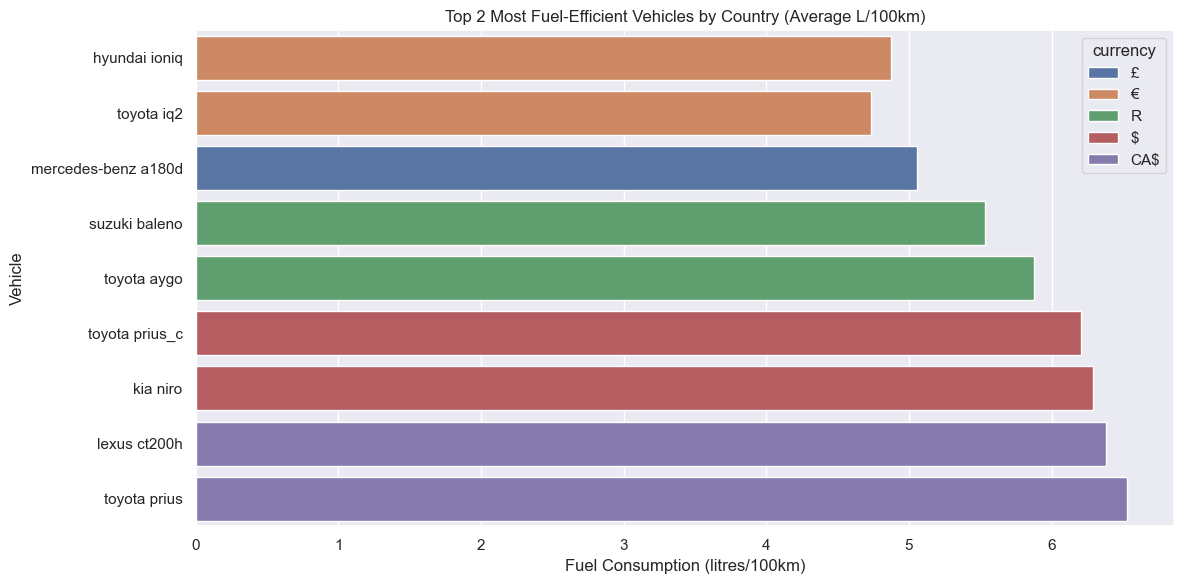

In [60]:
# Identify average fuel efficiency (litres per 100 km) per vehicle and country
vehicle_efficiency = (
    cleaned_top5_df
    .groupby(['car_make', 'car_model', 'currency'])['litres_per_100km']
    .mean()
    .reset_index(name='avg_litres_per_100km')
)

# Select top 2 most fuel-efficient vehicles per country
most_efficient_vehicles = (
    vehicle_efficiency
    .sort_values('avg_litres_per_100km')
    .groupby('currency')
    .head(2)
)

# Combine make and model for readability
most_efficient_vehicles['vehicle'] = (
    most_efficient_vehicles['car_make'] + ' ' + most_efficient_vehicles['car_model']
)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    x='avg_litres_per_100km',
    y='vehicle',
    data=most_efficient_vehicles.sort_values('avg_litres_per_100km'),
    hue='currency',
    dodge=False
)
plt.title('Top 2 Most Fuel-Efficient Vehicles by Country (Average L/100km)')
plt.xlabel('Fuel Consumption (litres/100km)')
plt.ylabel('Vehicle')
plt.tight_layout()
plt.show()


To ensure the values are reasonable, we can compare the calculated fuel efficiencies with known benchmarks for typical fuel consumption:
- Suzuki Celerio 1.0 GL: 4.2 L/100km
- Toyota Vitz 1.0 XR: 4.2 L/100km
- Renault Kwid: 4.4 L/100km
- Suzuki Swift 1.2: 4.4 L/100km
- Suzuki S-Presso 1.0: 4.6 L/100km
- Volkswagen Polo Vivo GT 1.0 TSI: 4.8 L/100km
- Honda Jazz: 5.6 L/100km
- Volkswagen Polo: 5.7 L/100km
* These figures are based on manufacturer claims and real-world data .

#### 7. Plot the difference in fuel efficiency for the top 5 Canadian vehicles between seasons. Would you expect to see big differences, and do you see them?

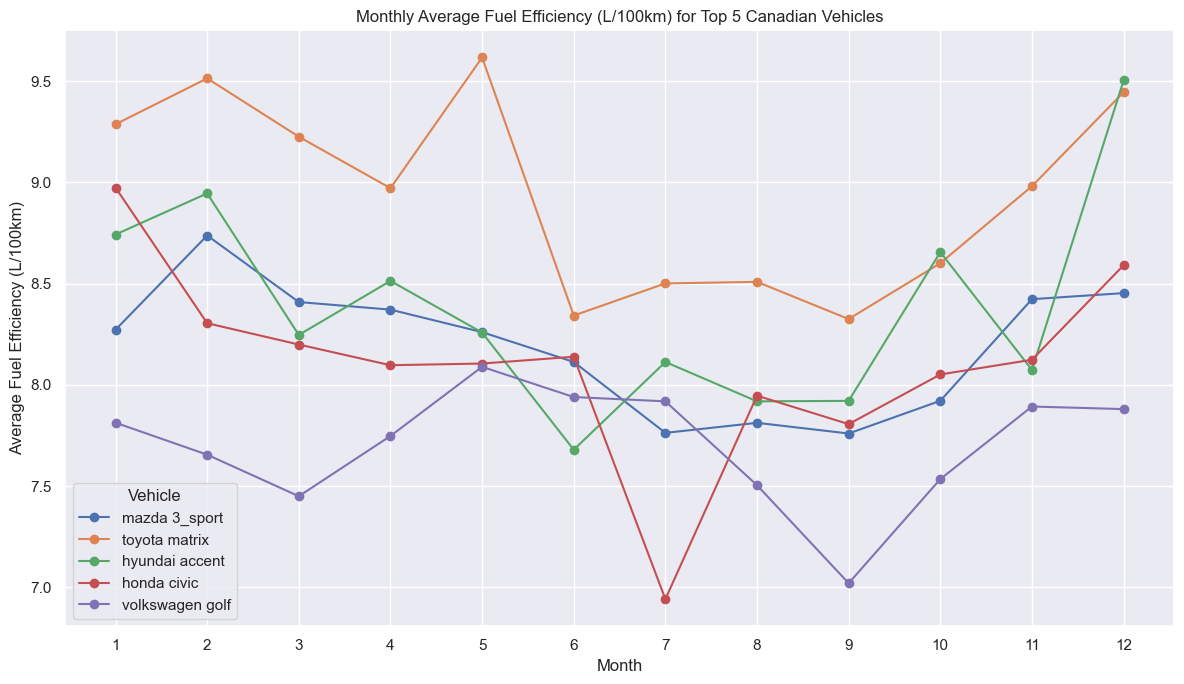

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for Canadian vehicles
ca_df = cleaned_top5_df[cleaned_top5_df['currency'] == 'CA$'].copy()

# Get top 5 most popular Canadian vehicles
ca_df['vehicle'] = ca_df['car_make'] + ' ' + ca_df['car_model']
top5_ca_vehicles = ca_df['vehicle'].value_counts().head(5).index

# Filter only top 5 vehicles
ca_top5 = ca_df[ca_df['vehicle'].isin(top5_ca_vehicles)]

# Group by vehicle and month, then calculate mean fuel efficiency
monthly_eff = ca_top5.groupby([ca_top5['date_fueled_proxy'].dt.month, 'vehicle'])['litres_per_100km'].mean().reset_index()

plt.figure(figsize=(12, 7))
for vehicle in top5_ca_vehicles:
    data = monthly_eff[monthly_eff['vehicle'] == vehicle]
    plt.plot(data['date_fueled_proxy'], data['litres_per_100km'], marker='o', label=vehicle)

plt.title('Monthly Average Fuel Efficiency (L/100km) for Top 5 Canadian Vehicles')
plt.ylabel('Average Fuel Efficiency (L/100km)')
plt.xlabel('Month')
plt.xticks(range(1, 13))
plt.legend(title='Vehicle')
plt.tight_layout()
plt.show()


<span style="color:yellow">Changing plot ranges to look at it seasonaly</span>

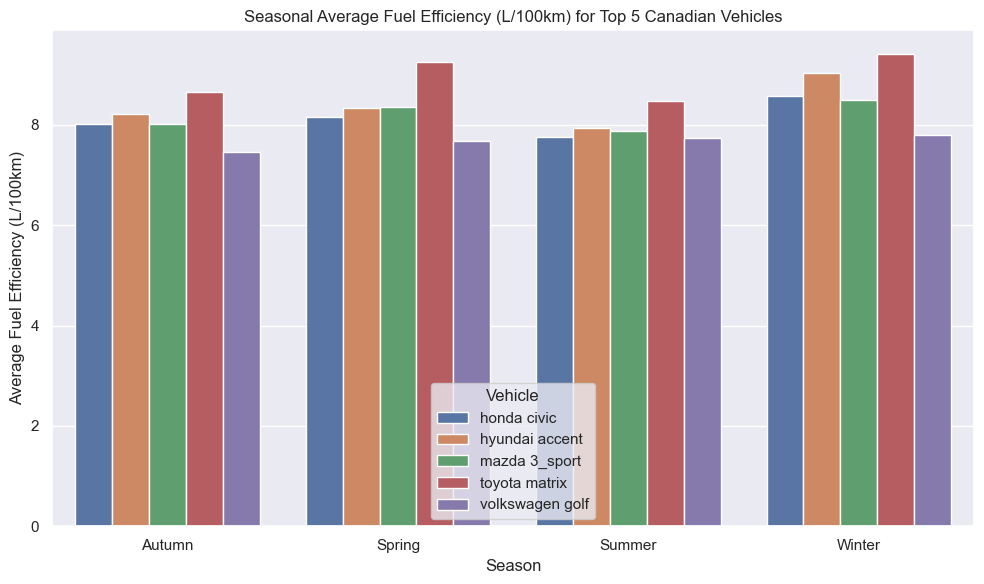

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define Canadian seasons by month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Filter for Canadian vehicles
ca_df = cleaned_top5_df[cleaned_top5_df['currency'] == 'CA$'].copy()
ca_df['vehicle'] = ca_df['car_make'] + ' ' + ca_df['car_model']
top5_ca_vehicles = ca_df['vehicle'].value_counts().head(5).index
ca_top5 = ca_df[ca_df['vehicle'].isin(top5_ca_vehicles)].copy()

# Add season column
ca_top5['season'] = ca_top5['date_fueled_proxy'].dt.month.apply(get_season)

# Group by vehicle and season, then calculate mean fuel efficiency
seasonal_eff = ca_top5.groupby(['season', 'vehicle'])['litres_per_100km'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='season', y='litres_per_100km', hue='vehicle', data=seasonal_eff)
plt.title('Seasonal Average Fuel Efficiency (L/100km) for Top 5 Canadian Vehicles')
plt.ylabel('Average Fuel Efficiency (L/100km)')
plt.xlabel('Season')
plt.legend(title='Vehicle')
plt.tight_layout()
plt.show()

-> Aircon and fuel expansion

#### 8. Show the correlations between fuel efficiency and other features. You should find that there is a relative strongly correlation with distance travelled, the age of the vehicle, and the model of vehicle. 

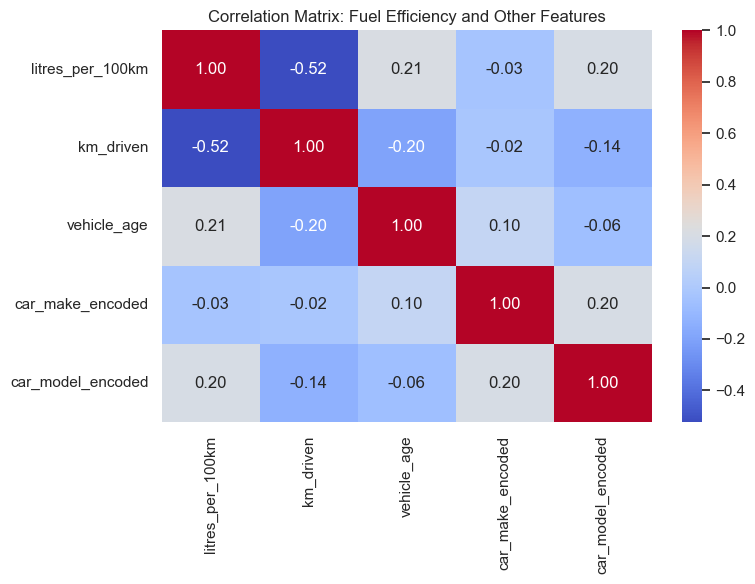

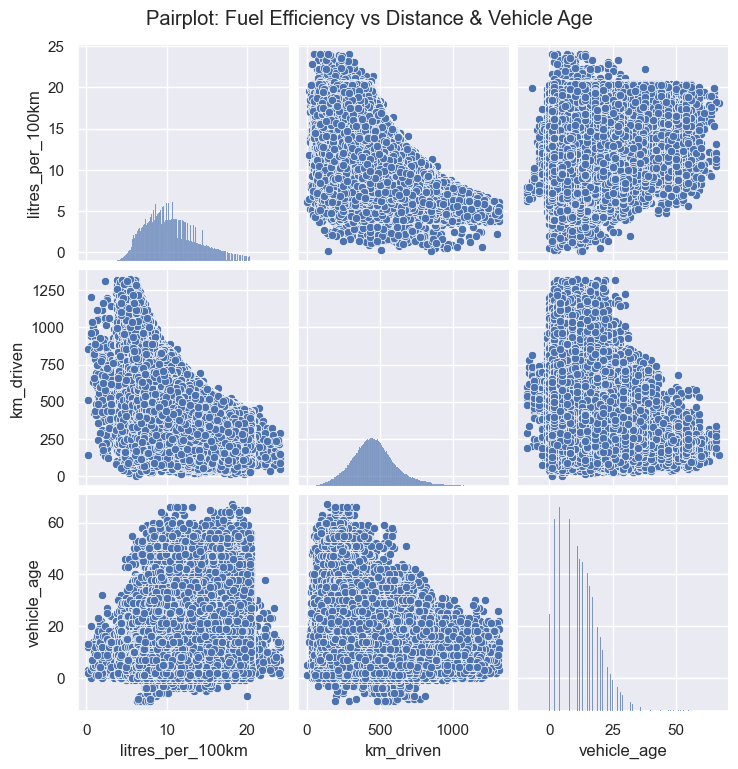

In [64]:
# Correlation analysis: Fuel efficiency vs other features
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns for correlation
corr_features = ['litres_per_100km', 'km_driven', 'vehicle_age', 'car_make', 'car_model']

# Encode categorical variables (car_make, car_model) for correlation
from sklearn.preprocessing import LabelEncoder
df_corr = cleaned_top5_df.copy()
df_corr['car_make_encoded'] = LabelEncoder().fit_transform(df_corr['car_make'].astype(str))
df_corr['car_model_encoded'] = LabelEncoder().fit_transform(df_corr['car_model'].astype(str))

# Compute correlation matrix
corr_matrix = df_corr[['litres_per_100km', 'km_driven', 'vehicle_age', 'car_make_encoded', 'car_model_encoded']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Fuel Efficiency and Other Features')
plt.tight_layout()
plt.show()

# Show pairplot for visual relationships
sns.pairplot(df_corr, vars=['litres_per_100km', 'km_driven', 'vehicle_age'])
plt.suptitle('Pairplot: Fuel Efficiency vs Distance & Vehicle Age', y=1.02)
plt.show()

<span style="color:yellow">Could not get meaningful intepretations from the plots above need help</span>

9. Use a random forest to get a list of the most important variables. How
different are they from each other, and how do these relate to the variables
from the correlations above? 

In [67]:
cleaned_top5_df.dtypes

user_id                      object
date_fueled_proxy    datetime64[ns]
currency                     object
total_spent_float           float64
cpg_float                   float64
car_make                     object
car_model                    object
car_year                    float64
km_driven                   float64
litres_filled               float64
litres_per_100km            float64
cost_per_gallon              object
total_spent                  object
date_fueled          datetime64[ns]
date_captured        datetime64[ns]
miles                       float64
odometer                    float64
gallons                     float64
mpg                         float64
user_url                     object
vehicle_age                 float64
cpl_float                   float64
vehicle                      object
km_diff                     float64
median_km                   float64
missed_fillup                  bool
dtype: object

In [ ]:
# Random Forest feature importance for fuel efficiency (stem plot)
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data
# Copy working dataframe
df_rf = cleaned_top5_df.copy()

# Extract temporal features
df_rf['month'] = df_rf['date_fueled_proxy'].dt.month               # 1-12
df_rf['day_of_week'] = df_rf['date_fueled_proxy'].dt.dayofweek     # 0=Monday, 6=Sunday

# Example: one-hot encode month and day_of_week
df_rf = pd.get_dummies(df_rf, columns=['month', 'day_of_week'], drop_first=True)

# Encode car_make and car_model as numeric labels
from sklearn.preprocessing import LabelEncoder
df_rf['car_make_encoded'] = LabelEncoder().fit_transform(df_rf['car_make'].astype(str))
df_rf['car_model_encoded'] = LabelEncoder().fit_transform(df_rf['car_model'].astype(str))

# Features
features = [
    'km_driven', 'vehicle_age', 'car_make_encoded', 'car_model_encoded',
    'total_spent_float', 'litres_filled', 'cpl_float', 'gallons', 'mpg'
] + [col for col in df_rf.columns if col.startswith('month') or col.startswith('day_of_week')]

X = df_rf[features]
y = df_rf['litres_per_100km']

print("Feature columns used for Random Forest:")
print(features)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit random forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
indices = importances.argsort()[::-1]
feature_names = [features[i] for i in indices]

# Stem plot (no use_line_collection)
plt.figure(figsize=(10, 6))
(markerline, stemlines, baseline) = plt.stem(range(len(importances)), importances[indices])
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(stemlines, 'color', 'b')
plt.yticks(fontsize=12)
plt.xticks(range(len(importances)), feature_names, rotation=45, ha='right', fontsize=12)
plt.title('Random Forest Feature Importances (Stem Plot)', fontsize=14)
plt.ylabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

print("Feature importances (descending):")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {importances[indices][i]:.4f}")

KeyboardInterrupt: 

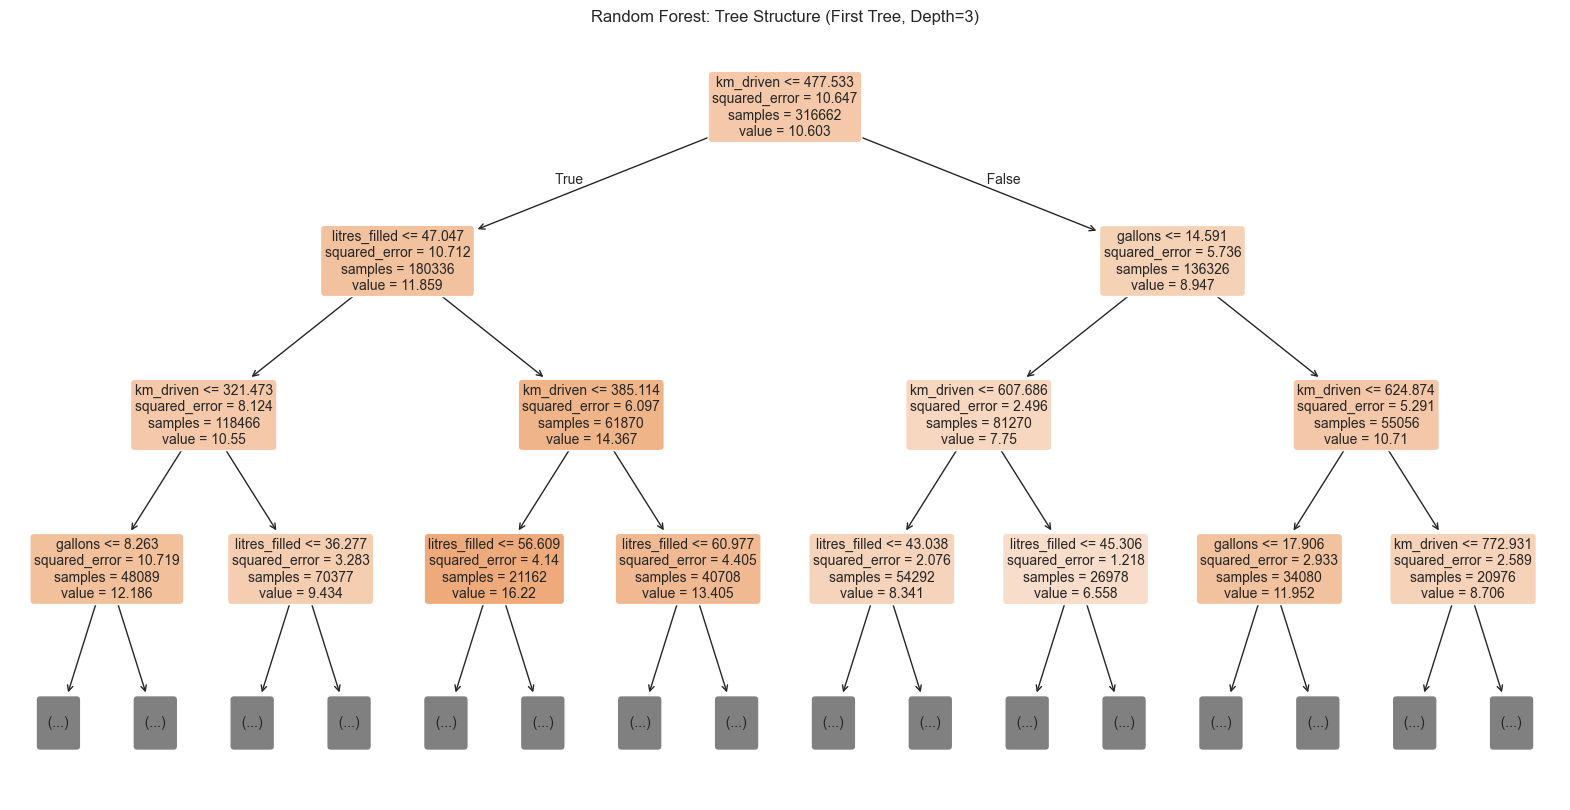

In [70]:
from sklearn.tree import plot_tree

# Visualize the first tree in the forest
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], feature_names=features, filled=True, rounded=True, max_depth=3, fontsize=10)
plt.title('Random Forest: Tree Structure (First Tree, Depth=3)')
plt.show()

<span style="color:yellow">Failed attempt at making this look like a traditional decision tree need help</span>

4.3 1. Filter the above dataset to focus on SA drivers.

In [78]:
sa_df = cleaned_top5_df[cleaned_top5_df['currency'] == 'R'].copy()

2. Plot the fuel prices over time for SA. 

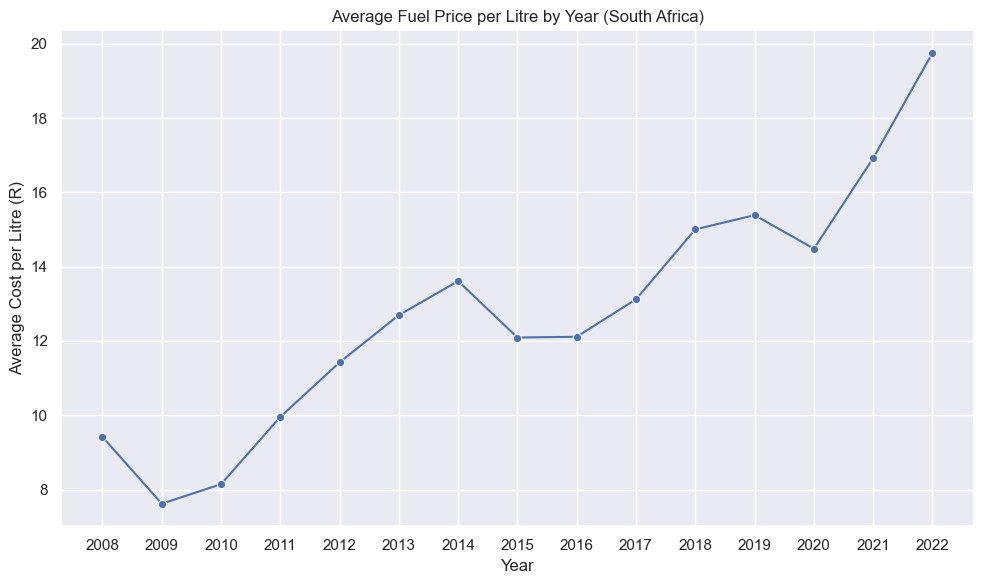

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for South African drivers
sa_df = cleaned_top5_df[cleaned_top5_df['currency'] == 'R'].copy()

# Group by year and calculate mean cost per litre
sa_df['year'] = sa_df['date_fueled_proxy'].dt.year
yearly_prices = sa_df.groupby('year')['cpl_float'].mean().reset_index()

# Plot
plt.figure(figsize=(10,6))
sns.lineplot(x=yearly_prices['year'], y=yearly_prices['cpl_float'], marker='o')
plt.title('Average Fuel Price per Litre by Year (South Africa)')
plt.xlabel('Year')
plt.ylabel('Average Cost per Litre (R)')
plt.xticks(yearly_prices['year'])
plt.tight_layout()
plt.show()

3. Using a suitable plot, show if the difference in the number of people refu-
eling on a Tuesday vs other days

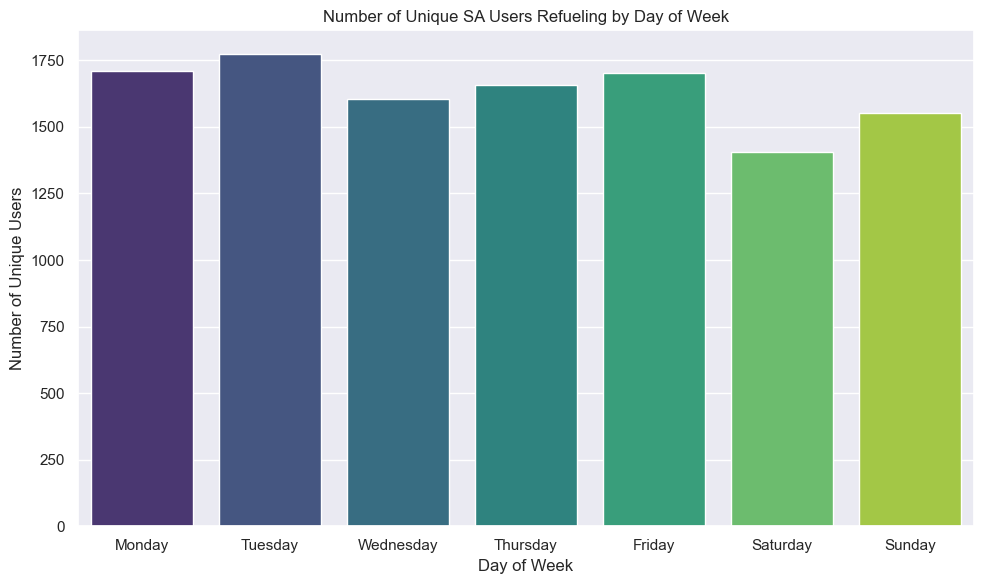

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the South African drivers dataframe
sa_df['day_of_week'] = sa_df['date_fueled_proxy'].dt.dayofweek
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sa_df['day_name'] = sa_df['day_of_week'].apply(lambda x: day_names[x])

# Count unique users refueling per day of week
users_per_day = sa_df.groupby('day_name')['user_id'].nunique().reindex(day_names)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=users_per_day.index, y=users_per_day.values, palette='viridis')
plt.title('Number of Unique SA Users Refueling by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Unique Users')
plt.tight_layout()
plt.show()

4. Now reduce your dataset to only the entries on the 1st Tuesday and 1st
Wednesday in SA every month.

In [74]:
import pandas as pd

# Ensure date column is datetime
sa_df['date'] = sa_df['date_fueled_proxy']

# Add day of week and day of month columns
sa_df['day_of_week'] = sa_df['date'].dt.dayofweek  # 0=Mon, 1=Tue, 2=Wed, ...
sa_df['day_of_month'] = sa_df['date'].dt.day
sa_df['year_month'] = sa_df['date'].dt.to_period('M')

# Find 1st Tuesday and 1st Wednesday for each month
first_tuesdays = sa_df[sa_df['day_of_week'] == 1].groupby('year_month')['day_of_month'].min()
first_wednesdays = sa_df[sa_df['day_of_week'] == 2].groupby('year_month')['day_of_month'].min()

# Filter for rows matching the 1st Tuesday or 1st Wednesday of each month
mask_tuesday = sa_df.apply(lambda row: row['day_of_week'] == 1 and row['day_of_month'] == first_tuesdays[row['year_month']], axis=1)
mask_wednesday = sa_df.apply(lambda row: row['day_of_week'] == 2 and row['day_of_month'] == first_wednesdays[row['year_month']], axis=1)
sa_first_tues_weds = sa_df[mask_tuesday | mask_wednesday].copy()

print(sa_first_tues_weds.sample(10))


         user_id date_fueled_proxy currency  total_spent_float  cpg_float  \
1038314   743392        2018-07-03        R             790.29      59.77   
445476    233303        2013-08-07        R              550.0      51.29   
205325    680562        2014-02-04        R             357.07      51.48   
256077   1046085        2021-12-07        R             888.86       75.6   
1029243   659293        2018-11-07        R             405.24      63.78   
198981    299784        2014-11-05        R              729.7      48.26   
901022    854744        2021-07-07        R             568.29      65.11   
902651    673100        2017-09-05        R             610.68      47.77   
620784    215781        2021-08-03        R             653.92      58.56   
408166    931048        2022-02-01        R             433.68      73.03   

           car_make          car_model  car_year          km_driven  \
1038314      nissan             navara    2008.0       297.90170872   
445476    

5. For each Tuesday and Wednesday, add an indicator for whether the price
goes up or the price goes down that month.

In [75]:
# Ensure year_month is present
sa_first_tues_weds['year_month'] = sa_first_tues_weds['date'].dt.to_period('M')

# Calculate average price per month for SA
monthly_avg = sa_df.groupby('year_month')['cpl_float'].mean().sort_index()

# Calculate price change direction for each month
monthly_change = monthly_avg.diff().apply(lambda x: 'up' if x > 0 else ('down' if x < 0 else 'same'))

# Map indicator to each row in sa_first_tues_weds
sa_first_tues_weds['price_change'] = sa_first_tues_weds['year_month'].map(monthly_change)

# Sample output
print(sa_first_tues_weds[['date', 'cpl_float', 'price_change']].sample(10))

              date          cpl_float price_change
1022165 2015-04-07 12.188898495804969           up
1068905 2021-04-06 15.771071525781462           up
34035   2021-05-04 16.600571770186047           up
24643   2013-07-02 12.350043447743438           up
532716  2017-12-05 13.200677456336676           up
388186  2012-06-05 11.930009884493982         down
556532  2019-04-03 15.491049150281823           up
491596  2018-05-01 13.459566067647662           up
1139112 2018-10-02 16.080152827040493           up
815106  2014-11-05 12.981414652879414         down


6. Do more people refuel on the first Wednesday of the month when the
prices goes down?

Number of unique users refueling on first Wednesday by price change:
price_change
down    278
up      296
Name: user_id, dtype: int64


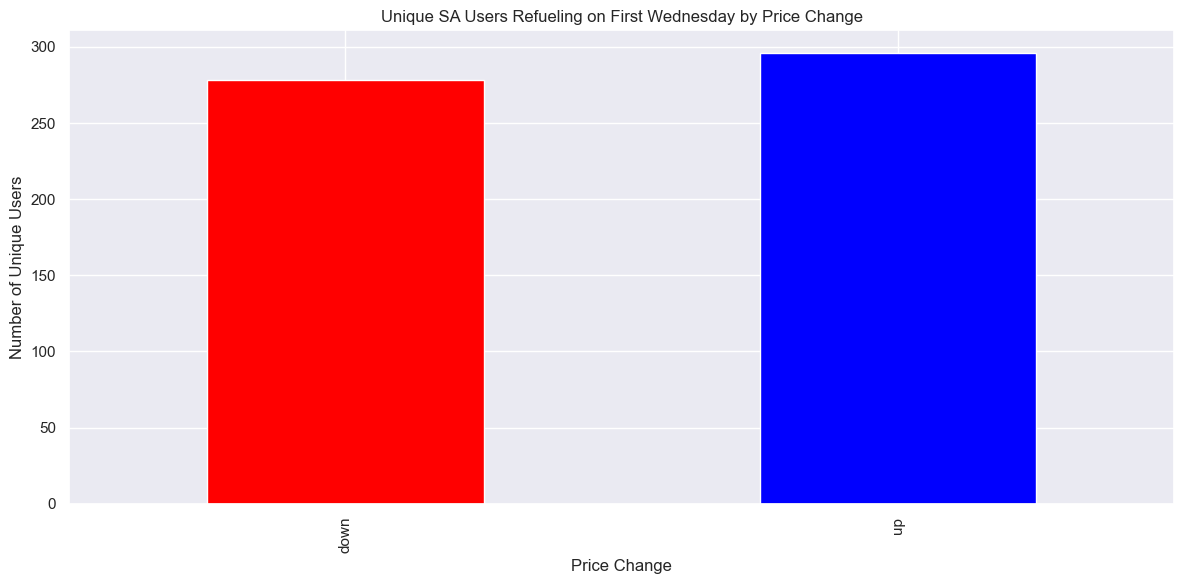

In [76]:
# Filter for first Wednesdays only
first_weds = sa_first_tues_weds[sa_first_tues_weds['day_of_week'] == 2]

# Group by price change and count unique users
weds_counts = first_weds.groupby('price_change')['user_id'].nunique()

print("Number of unique users refueling on first Wednesday by price change:")
print(weds_counts)

# Optional: visualize
import matplotlib.pyplot as plt
weds_counts.plot(kind='bar', color=['red' if x=='down' else 'blue' for x in weds_counts.index])
plt.title('Unique SA Users Refueling on First Wednesday by Price Change')
plt.xlabel('Price Change')
plt.ylabel('Number of Unique Users')
plt.tight_layout()
plt.show()

7. Do more people refuel on the first Tuesday of the month when the prices
goes up?

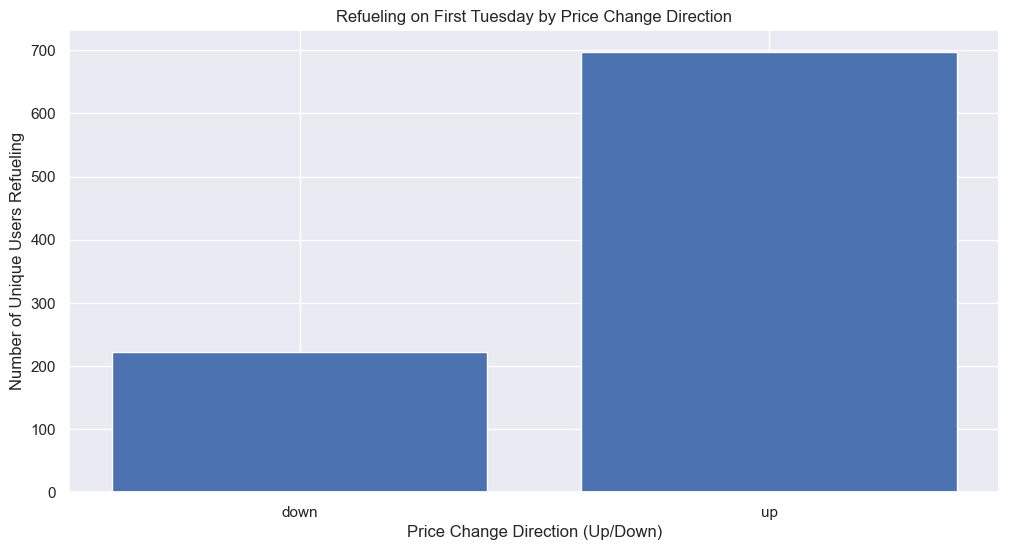

In [77]:
# Ensure 'date' is datetime
sa_df['date'] = pd.to_datetime(sa_df['date'])

# Get first Tuesday of each month
first_tuesdays = sa_df[sa_df['date'].dt.weekday == 1].copy()  # 0=Monday, 1=Tuesday
first_tuesdays['month_year'] = first_tuesdays['date'].dt.to_period('M')
first_tuesdays = first_tuesdays.sort_values('date').groupby('month_year').first().reset_index()

# Merge back to get all refueling events on first Tuesday
sa_first_tuesday = sa_df.merge(first_tuesdays[['date', 'month_year']], on=['date'], how='inner')

# Map price_change to sa_first_tuesday using monthly_change from cell 74
sa_first_tuesday['year_month'] = sa_first_tuesday['date'].dt.to_period('M')
sa_first_tuesday['price_change'] = sa_first_tuesday['year_month'].map(monthly_change)

# Count unique users by price change direction
result = sa_first_tuesday.groupby('price_change')['user_id'].nunique().reset_index()
result = result.rename(columns={'user_id': 'num_users'})

# Plot
import matplotlib.pyplot as plt
plt.bar(result['price_change'], result['num_users'])
plt.xlabel('Price Change Direction (Up/Down)')
plt.ylabel('Number of Unique Users Refueling')
plt.title('Refueling on First Tuesday by Price Change Direction')
plt.show()